# Overview of NLP (L90) Practical Session 3

Welcome to the third practical accompanying the Overview of NLP (L90) lecture course. Overall, the purpose of the practicals has been to build and evaluate an NLP system, specifically for named entity recognition (NER).

This session is the final one of our 3-part practical task.

1.   Explore and annotate a named entity recognition dataset (worth 10%) [link to colab](https://colab.research.google.com/drive/1J_jXBEFfxbDDuI_NcJpZPmubpNQCG6Kf?usp=sharing)
2.   Attempt feature-based NER (last time, worth 10%) [link to colab](https://colab.research.google.com/drive/1wUJ-9bmNmSZUlgA6TGQII6cJeGi9sBmw?usp=sharing)
3.   **Attempt NER with neural networks and write a report (this session, assignment due 3 December 3pm, worth 80%)**

You might find it useful to watch the short video we recorded last year (on the [part II](https://www.cl.cam.ac.uk/teaching/2122/NLP/video/) and [ACS](https://www.cl.cam.ac.uk/teaching/2122/L90/video/) teaching pages) -- there's a minor difference in that last year we had 40 on the course, this year 26. Also there will be an in-person discussion session on 10 November at 3pm in the Intel Lab: please come along to discuss the previous assignment and this new one!

Note that all submissions are made via the [course Moodle page](https://www.vle.cam.ac.uk/course/view.php?id=206751). We explain more what we expect in your reports at the end of this notebook. Ok, let's continue.

## Recap: Practical 1

First let's look back at the first assignment from practical 1, when we asked you to annotate 50 tweets from the training set, now that we've received all your submissions. Hopefully you received some feedback on Moodle, including your agreement kappa with the original file (if not, let us know: apc38).

Overall, the agreement among the 26 of you was a Fleiss's kappa of .708 (= 'substantial' agreement per Landis & Koch 1977, 'The measurement of observer agreement for categorical data' -- this is pretty good for NLP annotation, in our experience).

If we take the same max-recall approach as the task organisers did -- accepting all named entity labels (with a bit of downstream inspection) -- then we'd have a new training file in which there are 111 named entities (compared to 41 in the original file). If we instead take a majority vote approach then we'd have 47 named entities. So we could end up with quite different training data, with a greater variety of named entities identified, if we were to continue this group annotation process on the whole training file.

This is obviously not complete agreement but it would be unrealistic to expect that for all but the most trivial of natural language annotation tasks, as you probably realise by now. The more practical question is: how do we handle the inevitable disagreements in language annotation? Note that besides the majority vote or max-recall ways of handling multiple annotation, there has been work on making use of disagreement as a useful training signal in computational modelling (for just one example see [Plank et al 2014](https://aclanthology.org/E14-1078/)), and also a review of how to use such information in evaluation ([Basile et al 2021](https://aclanthology.org/2021.bppf-1.3/)).

There was one entity in the original file which you unanimously decided is not in fact a named entity: `vodka B-product`. And there were 16 word tokens which you labelled as being part of named entities, but which were not in the gold file:

```
 1 Green
 2 Newsfeed
 3 london
 4 eurovision
 5 cody
 6 NY
 7 Epix      
 8 Movie     
 9 Channel   
10 The       
11 DeAndre   
12 Way       
13 1ST       
14 AVE       
15 HKY       
16 Break
```

Most of these indeed seem to be named entities: it's not clear why 'Green Newsfeed', 'london fashion week', and 'eurovision' weren't identified as named entities in the original file (perhaps regional effects: recall that the training file annotator was US-based).

'cody' is debatable, because it's clearly a person (the context: "hopefully we got cody's ipod in the mail today") but not as far as we know a well known person. So this touches on a philosophical problem with NER: at what point does someone become sufficiently widely known for them to be considered a _person_ in a named entity sense? (see also 'wood', someone's nickname: "Wingo tellin me and wood...").

'1ST AVE HKY' appears to refer to an address in Hickory, North Carolina, USA (or at least: that's what a Google search indicates). The reason for this entity not being identified by the annotators is another common problem: that of local places not being generally known. In a sense, this is one way to decide if a location is of interest, by revealing how well-known it is: but this leads to a problem of bias relating to the geographical knowledge and experience of the annotators.

We'll let you look at the texts again and discuss these proposed additional named entities in your final report, if you wish to (no requirement, but it might enrich it). Here's the [sample file](https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17train_sample_blank.txt) again for convenience.

Remember, however high or low your agreement score with the original annotation, it's not so much a matter of 'correct' or 'incorrect', but more 'agreement' and 'disagreement'. What that tells us about language annotation, and what we do with disagreements, are the interesting questions we think.

### Assignment 2

We'll be in touch soon with feedback relating to assignment 2 (remember that it's a tick). If you don't see feedback on Moodle within one week of the deadline please get in touch (apc38) -- also we've had reports that you may need to clear your Moodle cache so that you can see our comments (we reported this problem to the Moodle helpdesk).

## Today: Practical 3

Today we'll set your final assignment which counts for 80% of your grade. It involves a neural network approach to the NER task, and you are required to submit a written report about the practical work as a whole. We'll explain the task and the assignment requirements some more below.

### Neural network approaches to NLP

You'll no doubt be aware from the lectures and from your general knowledge that neural networks have had a transformative effect on NLP in recent years. So we thought it apt to build a neural network classifier for NER in this practical. We can't assume that it will lead to an improvement in performance, because "deep learning" isn't always best (despite the hype), but wanted to have a look at the implementation details of a neural network in practice. Note that we assume that you've picked up a conceptual framework for neural networks from the lectures.

### Preparing the training data

Ok let's return to what we did in practical 2 when we prepared the training texts by converting all PoS-tags and named entity labels to integer values. This is what the training data looks like at first:

In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf

def init_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
import pandas as pd
wnuttrain = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17train_clean_tagged.txt'
train = pd.read_table(wnuttrain, header=None, names=['token', 'label', 'bio_only', 'upos'])
# NB: don't drop the empty lines between texts yet, they are needed for sequence splits (they show up as NaN in the data frame)
train.head(n=30)

,token,label,bio_only,upos
0,@paulwalk,O,O,NOUN
1,It,O,O,PRON
2,'s,O,O,AUX
3,the,O,O,DET
4,view,O,O,NOUN
5,from,O,O,ADP
6,where,O,O,ADV
7,I,O,O,PRON
8,'m,O,O,X
9,living,O,O,NOUN


This time, the input to our neural classifier will be the words themselves, so let's create an index for our word types and then use this to convert our word tokens into integers. As a result, every instance of word token 'It' will be replaced with integer 1 (note that our vocabulary is case sensitive; quite often in NLP all words are lower-cased before indexing but for the task of NER we know that character casing is useful information to retain).

In [ ]:
import numpy as np

# in order to convert word tokens to integers: list the set of token types
token_vocab = train.token.unique().tolist()
oov = len(token_vocab)  # OOV (out of vocabulary) token as vocab length (because that's max.index + 1)

# convert word tokens to integers
def token_index(tok):
    ind = tok
    if not pd.isnull(tok):  # new since last time: deal with the empty lines which we didn't drop yet
        if tok in token_vocab:  # if token in vocabulary
            ind = token_vocab.index(tok)
        else:  # else it's OOV
            ind = oov
    return ind

# training labels: convert BIO to integers
def bio_index(bio):
    ind = bio
    if not pd.isnull(bio):  # deal with empty lines
        if bio=='B':
            ind = 0
        elif bio=='I':
            ind = 1
        elif bio=='O':
            ind = 2
    return ind

# pass a data frame through our feature extractor
def extract_features(txt,istest=False):
    txt_copy = txt.copy()
    tokinds = [token_index(u) for u in txt_copy['token']]
    txt_copy['token_indices'] = tokinds
    if not istest:  # can't do this with the test set
        bioints = [bio_index(b) for b in txt_copy['bio_only']]
        txt_copy['bio_only'] = bioints
    return txt_copy

train_copy = extract_features(train)
train_copy.head(n=30)

,token,label,bio_only,upos,token_indices
0,@paulwalk,O,2.0,NOUN,0.0
1,It,O,2.0,PRON,1.0
2,'s,O,2.0,AUX,2.0
3,the,O,2.0,DET,3.0
4,view,O,2.0,NOUN,4.0
5,from,O,2.0,ADP,5.0
6,where,O,2.0,ADV,6.0
7,I,O,2.0,PRON,7.0
8,'m,O,2.0,X,8.0
9,living,O,2.0,NOUN,9.0


Now we need to convert the table format to text sequences, ready for input to our neural network classifier.

In [ ]:
def tokens2sequences(txt_in,istest=False):
    '''
    Takes panda dataframe as input, copies, and adds a sequence index based on full-stops.
    Outputs a dataframe with sequences of tokens, named entity labels, and token indices as lists.
    '''
    txt = txt_in.copy()
    txt['sequence_num'] = 0
    seqcount = 0
    for i in txt.index:  # in each row...
        txt.loc[i,'sequence_num'] = seqcount  # set the sequence number
        if pd.isnull(txt.loc[i,'token']):  # increment sequence counter at empty lines
            seqcount += 1
    # now drop the empty lines, group by sequence number and output df of sequence lists
    txt = txt.dropna()
    if istest:  # looking ahead: the test set doesn't have labels
        txt_seqs = txt.groupby(['sequence_num'],as_index=False)[['token', 'token_indices']].agg(lambda x: list(x))
    else:  # the dev and training sets do have labels
        txt_seqs = txt.groupby(['sequence_num'],as_index=False)[['token', 'bio_only', 'token_indices']].agg(lambda x: list(x))
    return txt_seqs

print("This cell takes a little while to run: be patient :)")
train_seqs = tokens2sequences(train_copy)
train_seqs.head()

This cell takes a little while to run: be patient :)


,sequence_num,token,bio_only,token_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10...."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46...."
3,3,"[today, is, my, last, day, at, the, office, .]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[51.0, 52.0, 53.0, 23.0, 54.0, 55.0, 3.0, 56.0..."
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0..."


Next we need to figure out the input text length we'll be passing to our neural networks. Neural nets are of pre-defined dimensions, and so we need all texts to carry the same number of tokens. So our first question is: what's the longest sequence in our dataset?

In [ ]:
def find_longest_sequence(txt,longest_seq):
    '''find the longest sequence in the dataframe'''
    for i in txt.index:
        seqlen = len(txt['token'][i])
        if seqlen > longest_seq:  # update high water mark if new longest sequence encountered
            longest_seq = seqlen
    return longest_seq

train_longest = find_longest_sequence(train_seqs, 0)
print('The longest sequence in the training set is %i tokens long' % train_longest)

The longest sequence in the training set is 41 tokens long


Let's also load and check the longest sequence length in the dev and test sets.

In [ ]:
# the dev set
wnutdev = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17dev_clean_tagged.txt'
dev = pd.read_table(wnutdev, header=None, names=['token', 'label', 'bio_only', 'upos'])
dev_copy = extract_features(dev)
dev_seqs = tokens2sequences(dev_copy)
dev_longest = find_longest_sequence(dev_seqs, 0)
print('The longest sequence in the dev set is %i tokens long' % dev_longest)

# the test set
wnuttest = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17test_clean_tagged.txt'
test = pd.read_table(wnuttest, header=None, names=['token', 'upos'])
test_copy = extract_features(test, True)
test_seqs = tokens2sequences(test_copy, True)
test_longest = find_longest_sequence(test_seqs, 0)
print('The longest sequence in the test set is %i tokens long' % test_longest)

The longest sequence in the dev set is 82 tokens long
The longest sequence in the test set is 105 tokens long


In [ ]:
def find_sequence_lengths(txt):
    seq_lengths = []
    for i in txt.index:
        seq_lengths.append(len(txt['token'][i]))
    return seq_lengths

train_seq_lengths = find_sequence_lengths(train_seqs)
print('Training set sequences: ')
print(f'n = {len(train_seq_lengths)}, min = {min(train_seq_lengths)}, max = {max(train_seq_lengths)}, mean = {np.mean(train_seq_lengths)}, median = {np.median(train_seq_lengths)}')
print()

dev_seq_lengths = find_sequence_lengths(dev_seqs)
print('Dev set sequences: ')
print(f'n = {len(dev_seq_lengths)}, min = {min(dev_seq_lengths)}, max = {max(dev_seq_lengths)}, mean = {np.mean(dev_seq_lengths)}, median = {np.median(dev_seq_lengths)}')
print()

test_seq_lengths = find_sequence_lengths(test_seqs)
print('Test set sequences: ')
print(f'n = {len(test_seq_lengths)}, min = {min(test_seq_lengths)}, max = {max(test_seq_lengths)}, mean = {np.mean(test_seq_lengths)}, median = {np.median(test_seq_lengths)}')

Training set sequences: 
n = 3375, min = 1, max = 41, mean = 18.440296296296296, median = 18.0

Dev set sequences: 
n = 993, min = 1, max = 82, mean = 15.49043303121853, median = 13.0

Test set sequences: 
n = 1283, min = 1, max = 105, mean = 18.178487918939986, median = 15.0


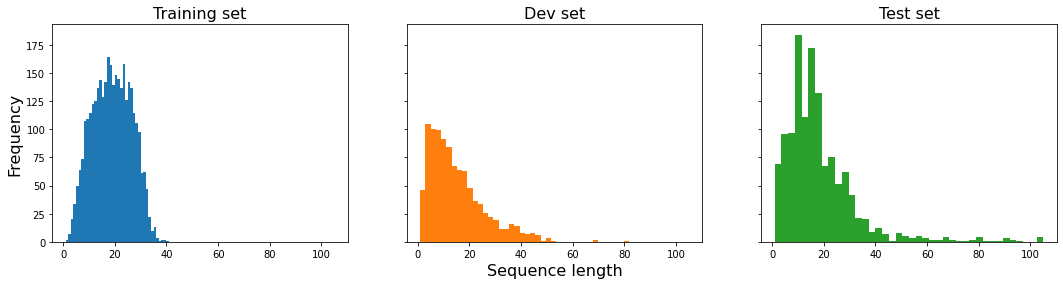

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)

axes[0].hist(train_seq_lengths, bins=40, color='tab:blue')
axes[0].set_ylabel('Frequency', fontsize=16)
axes[0].set_title('Training set', fontsize=16)

axes[1].hist(dev_seq_lengths, bins=40, color='tab:orange')
axes[1].set_xlabel('Sequence length', fontsize=16)
axes[1].set_title('Dev set', fontsize=16)

axes[2].hist(test_seq_lengths, bins=40, color='tab:green')
axes[2].set_title('Test set', fontsize=16)

plt.savefig('sequence-lengths-histogram.png', bbox_inches='tight')
plt.show()

Overall the 105 length sequence in the test set is the longest. So for our initial experiments let's fix the input length at 105 tokens, padding out any sequences which are shorter than this length (note that texts can be truncated too, they don't have to be padded). We do have access to the test set in this shared task, so let's use the information available to us; but in some shared tasks you don't get access to the test set (which is why your code needs to be able to handle truncation as well as padding). Feel free to experiment with this sequence length in your assignment.

To pad or truncate the sequences, we can use the handy `pad_sequences` function in Keras, a deep learning API written in Python.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# set maximum sequence length
seq_length = test_longest

# a new dummy token index, one more than OOV
padtok = oov + 1
print('The padding token index is %i' % padtok)

# use pad_sequences, padding or truncating at the end of the sequence (default is 'pre')
train_seqs_padded = pad_sequences(train_seqs['token_indices'].tolist(), maxlen=seq_length,
                                  dtype='int32', padding='post', truncating='post', value=padtok)
print('Example of padded token sequence:')
print(train_seqs_padded[1])

The padding token index is 14802
Example of padded token sequence:
[   26    27    28    29    30    31    32    10    33    34    35    36
    13    37    38 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802]


All those 14802s after 10 (the full stop) are padding, so that's our training texts now ready as fixed-length sequences.

Now in named entity recognition we are predicting a label for each input token -- a 'many-to-many' or 'sequence labelling' scenario analogous to time series prediction (which is why you sometimes see 'time' alluded to in the network layers themselves). Every input token requires an output token: the words in the original sentence have a label 0, 1 or 2, and we'll add the label 3 for padding tokens.

So that the labels are prepared as binary values, we convert the label sequences to a one-hot encoding using the keras `to_categorical` function.

In [ ]:
from tensorflow.keras.utils import to_categorical

# get lists of named entity labels, padded with a null label (=3)
padlab = 3
train_labs_padded = pad_sequences(train_seqs['bio_only'].tolist(), maxlen=seq_length,
                                  dtype='int32', padding='post', truncating='post', value=padlab)

# convert those labels to one-hot encoding
n_labs = 4  # we have 3 labels: B, I, O (0, 1, 2) + the pad label 3
train_labs_onehot = [to_categorical(i, num_classes=n_labs) for i in train_labs_padded]

# follow the print outputs below to see how the labels are transformed
print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs.loc[1])
print('Length of input sequence: %i' % len(train_seqs_padded[1]))
print('Length of label sequence: %i' % len(train_labs_onehot[1]))
print(train_labs_padded[1][:11])
print(train_labs_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
Name: 1, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[2 2 2 2 0 2 2 2 2 2 2]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


Now we need to do the same to the dev set (pad the token and label sequences, and convert the latter to one-hot encoding):

In [ ]:
# now process the dev set in the same way: padding the tokens & labels, and one-hot encoding the labels
dev_seqs_padded = pad_sequences(dev_seqs['token_indices'].tolist(), maxlen=seq_length,
                                dtype='int32', padding='post', truncating='post', value=padtok)
dev_labs_padded = pad_sequences(dev_seqs['bio_only'].tolist(), maxlen=seq_length,
                                dtype='int32', padding='post', truncating='post', value=padlab)
dev_labs_onehot = [to_categorical(i, num_classes=n_labs) for i in dev_labs_padded]

print('Dev set padded label sequence and one-hot encoding (first 10 tokens):')
print(dev_seqs.loc[2])
print('Length of input sequence: %i' % len(dev_seqs_padded[1]))
print('Length of label sequence: %i' % len(dev_labs_onehot[1]))
print(dev_labs_padded[2][:11])
print(dev_labs_onehot[2][:11])

Dev set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     2
token            [All, I, ', ve, been, doing, is, BINGE, watchi...
bio_only         [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...
Name: 2, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[2 2 2 2 2 2 2 2 2 0 1]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


### Building a neural network classifier

Ok that's everything prepared for neural network classification. Let's build a basic model using Keras and Tensorflow, two popular libraries for neural network machine learning.

First we prepare the input data as numpy arrays, list the metrics for model evaluation, define some important hyperparameters, then build the model layer by layer. It's a sequential model with an embedding layer followed by bidirectional LSTM, then a dropout layer before a final dense layer with softmax activation. We have early stopping criteria to halt training if improvements are not seen after a certain number of epochs, and at the end we print the model summary which shows the shape of the model layer by layer and number of parameters we are training.

In [ ]:
# load Keras and TensorFlow
from tensorflow import keras
import tensorflow as tf

# prepare sequences and labels as numpy arrays, check dimensions
X = np.array(train_seqs_padded)
y = np.array(train_labs_onehot)
print('Input sequence dimensions (n.docs, seq.length):')
print(X.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):')
print(y.shape)

# our final vocab size is the padding token + 1 (OR length of vocab + OOV + PAD)
vocab_size = padtok+1
print(vocab_size==len(token_vocab)+2)
embed_size = 128  # try an embedding size of 128 (could tune this)

# list of metrics to use: true & false positives, negatives, accuracy, precision, recall, area under the curve
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

# our model has the option for an label prediction bias, it's sequential, starts with an embedding layer, then bi-LSTM,
# a dropout layer follows for regularisation, and a dense final layer with softmax activation to output class probabilities
# we compile with the Adam optimizer at a low learning rate, use categorical cross-entropy as our loss function
def make_model(metrics=METRICS, output_bias=None, seed=42):
    init_random_seed(seed)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=seq_length, mask_zero=True, trainable=True),
        keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  # 2 directions, 50 units each, concatenated (can change this)
        keras.layers.Dropout(0.5),
        keras.layers.TimeDistributed(keras.layers.Dense(n_labs, activation='softmax', bias_initializer=output_bias)),
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
    return model

# early stopping criteria based on area under the curve: will stop if no improvement after 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)

# the number of training epochs we'll use, and the batch size (how many texts are input at once)
EPOCHS = 100
BATCH_SIZE = 32

print('**Defining a neural network**')
model = make_model()
model.summary()

Input sequence dimensions (n.docs, seq.length):
(3375, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):
(3375, 105, 4)
True
**Defining a neural network**
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 105, 128)          1894784   
                                                                 
 bidirectional (Bidirectiona  (None, 105, 100)         71600     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 105, 100)          0         
                                                                 
 time_distributed (TimeDistr  (None, 105, 4)           404       
 ibuted)                                                         
                                                                 
Total

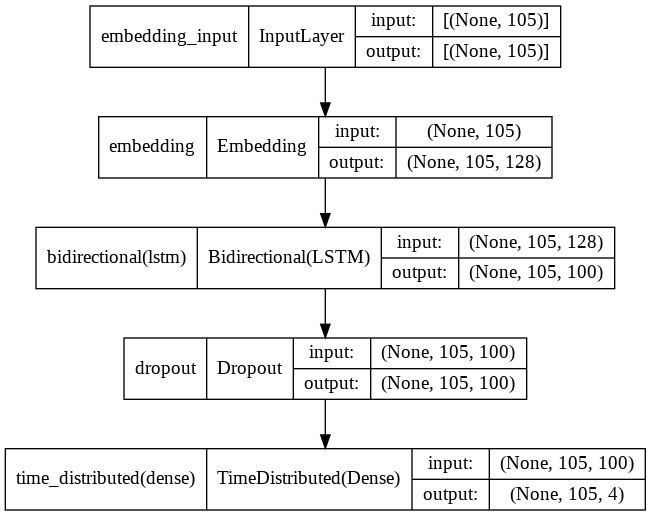

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

Check the model works, emitting predictions even without being fitted to our training data.

In [ ]:
# check the model works on the first 10 texts
model.predict(X[:10])

array([[[0.26264954, 0.30658948, 0.29201552, 0.13874543],
        [0.25982302, 0.30482107, 0.295707  , 0.13964888],
        [0.25995025, 0.30405137, 0.29404813, 0.14195028],
        ...,
        [0.26684064, 0.29940453, 0.29173052, 0.14202441],
        [0.2661049 , 0.30062246, 0.2918345 , 0.14143816],
        [0.26505673, 0.30189705, 0.29235023, 0.140696  ]],

       [[0.26011866, 0.30325598, 0.2946085 , 0.14201683],
        [0.25707033, 0.30424473, 0.29590333, 0.14278154],
        [0.2617999 , 0.30128443, 0.2960353 , 0.14088042],
        ...,
        [0.26684064, 0.29940453, 0.29173052, 0.14202441],
        [0.2661049 , 0.30062246, 0.2918345 , 0.14143816],
        [0.26505673, 0.30189705, 0.29235023, 0.14069602]],

       [[0.2588833 , 0.30413416, 0.29500148, 0.14198105],
        [0.2634686 , 0.30092794, 0.2928198 , 0.14278367],
        [0.2602056 , 0.30339673, 0.29468152, 0.14171618],
        ...,
        [0.26684064, 0.29940453, 0.29173052, 0.14202441],
        [0.2661049 , 0.300622

We can even evaluate these initial predictions and calculate loss (lower is better).

In [ ]:
# evaluate our initial model
results = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.8116


We know we have imbalanced classes in our dataset (only a few named entities), a problem exacerbated by padding the sequences. So let's try and help the situation by setting an intial bias based on the prior distribution of labels in our training set. The following code block calculates those proportions on the padded training sequences.

In [ ]:
# figure out the label distribution in our fixed-length texts
from collections import Counter

all_labs = [l for lab in train_labs_padded for l in lab]
label_count = Counter(all_labs)
total_labs = len(all_labs)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias=[(label_count[0]/total_labs), (label_count[1]/total_labs),
              (label_count[2]/total_labs), (label_count[3]/total_labs)]
print('Initial bias:')
print(initial_bias)

# pass the bias to the model and re-evaluate
model = make_model(output_bias=initial_bias)
results = model.evaluate(X, y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Counter({3: 292139, 2: 59095, 0: 1964, 1: 1177})
354375
Initial bias:
[0.005542151675485009, 0.0033213403880070548, 0.1667583774250441, 0.8243781305114638]
Loss: 0.1107


Now we can use that initial bias and fit the model on the training set, validating on our dev set. The print statements tell us our epoch number, batch number and metrics on the training and validation sets. With up to 100 epochs this could take a while, so make sure your machine won't go to sleep, start the next code block running, and [take a break](https://xkcd.com/1838/) :)

In [ ]:
# prepare the dev sequences and labels as numpy arrays
dev_X = np.array(dev_seqs_padded)
dev_y = np.array(dev_labs_onehot)

# re-initiate model with bias
model = make_model(output_bias=initial_bias)

# and fit...
model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

# save the model
model.save('BiLSTM/BiLSTM.h5')

Epoch 1/100
106/106 [==============================] - 52s 413ms/step - loss: 0.1885 - tp: 322346.0000 - fp: 12896.0000 - tn: 2113342.0000 - fn: 386400.0000 - accuracy: 0.8592 - precision: 0.9615 - recall: 0.4548 - auc: 0.9817 - val_loss: 0.0605 - val_tp: 103025.0000 - val_fp: 1240.0000 - val_tn: 311555.0000 - val_fn: 1240.0000 - val_accuracy: 0.9941 - val_precision: 0.9881 - val_recall: 0.9881 - val_auc: 0.9989
Epoch 2/100
106/106 [==============================] - 41s 388ms/step - loss: 0.0459 - tp: 351055.0000 - fp: 3240.0000 - tn: 1059879.0000 - fn: 3318.0000 - accuracy: 0.9954 - precision: 0.9909 - recall: 0.9906 - auc: 0.9992 - val_loss: 0.0505 - val_tp: 103022.0000 - val_fp: 1242.0000 - val_tn: 311553.0000 - val_fn: 1243.0000 - val_accuracy: 0.9940 - val_precision: 0.9881 - val_recall: 0.9881 - val_auc: 0.9994
Epoch 3/100
106/106 [==============================] - 41s 391ms/step - loss: 0.0327 - tp: 351134.0000 - fp: 2914.0000 - tn: 1060205.0000 - fn: 3239.0000 - accuracy: 0.995

We can now evaluate our model on the dev set in full. Let's check the distribution of predicted labels before going further, flattening the list of predictions so as to count the labels:

In [ ]:
# use argmax to figure out the class with highest probability per token
preds = np.argmax(model.predict(dev_seqs_padded), axis=-1)
flat_preds = [p for pred in preds for p in pred]
print(Counter(flat_preds))

Counter({3: 88887, 2: 15377, 0: 1})


But we encounter the same old problem as last time: that of not predicting 0s or 1s, our named entity but very rare B and I labels.

Now, there are various techniques you can try to deal with class imbalance with neural networks. This might be the subject of your report for assignment 3.

Here, we'll try one of those techniques which is to down-weight our non named entity labels 2 and 3 ('outside' and 'pad'). To do this we will re-train the model using weighted encoded labels, obtained by multiplying positions 0 and 1 (B and I) in our previous one-hot encoded labels by 1 and positions 2 and 3 by .1 (these are arbitrary weights; you could try tuning them).

In [ ]:
# use deep copy to ensure we aren't updating original values
import copy
train_weights_onehot = copy.deepcopy(train_labs_onehot)

# our first-pass class weights: normal for named entities (0 and 1), down-weighted for non named entities (2 and 3)
class_wts = [1, 1, .1, .1]

# apply our weights to the label lists
for i, labs in enumerate(train_weights_onehot):
    for j, lablist in enumerate(labs):
        lablistaslist = lablist.tolist()
        whichismax = lablistaslist.index(max(lablistaslist))
        train_weights_onehot[i][j][whichismax] = class_wts[whichismax]

# what's this like, before and after?
print('Initial one-hot label encoding:')
print(train_labs_onehot[1][:11])

print('Weighted label encoding:')
print(train_weights_onehot[1][:11])

Initial one-hot label encoding:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Weighted label encoding:
[[0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [1.  0.  0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.1 0. ]]


Ok let's use those weighted encodings to fit a new model, again this will take some time, so take another break away from your screen (but don't let your machine go to sleep otherwise you'll lose your Colab session) unless you enjoy watching the epochs progress... (it can be a little mesmerising, I sometimes think).

In [ ]:
# now try the weighted one-hot encoding
y = np.array(train_weights_onehot)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):')
print(np.shape(y))

model2 = make_model(output_bias=initial_bias)
model2.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):
(3375, 105, 4)
Epoch 1/100
106/106 [==============================] - 53s 413ms/step - loss: 0.0377 - tp: 311051.0000 - fp: 9201.0000 - tn: 2117037.0000 - fn: 397695.0000 - accuracy: 0.7468 - precision: 0.9713 - recall: 0.4389 - auc: 0.9819 - val_loss: 0.0771 - val_tp: 102844.0000 - val_fp: 1216.0000 - val_tn: 311579.0000 - val_fn: 1421.0000 - val_accuracy: 0.9937 - val_precision: 0.9883 - val_recall: 0.9864 - val_auc: 0.9993
Epoch 2/100
106/106 [==============================] - 42s 393ms/step - loss: 0.0194 - tp: 345436.0000 - fp: 1790.0000 - tn: 1061329.0000 - fn: 8937.0000 - accuracy: 0.7488 - precision: 0.9948 - recall: 0.9748 - auc: 0.9996 - val_loss: 0.0563 - val_tp: 102042.0000 - val_fp: 886.0000 - val_tn: 311909.0000 - val_fn: 2223.0000 - val_accuracy: 0.9925 - val_precision: 0.9914 - val_recall: 0.9787 - val_auc: 0.9996
Epoch 3/100
106/106 [==============================] - 42s 394ms/step - loss: 0.0119 

And let's re-evaluate this second model on the dev set:

In [ ]:
preds = np.argmax(model2.predict(dev_seqs_padded), axis=-1)
flat_preds = [p for pred in preds for p in pred]
print(Counter(flat_preds))

Counter({3: 88894, 2: 14866, 0: 505})


That's better: our model has now predicted some named entities.

Remember that these predictions are still padded to a fixed number of tokens. We need to convert these sequences back to their original lengths so that we can properly evaluate the predictions against the gold labels.

In [ ]:
# start a new column for the model predictions
dev_seqs['prediction'] = ''

# for each text: get original sequence length and trim predictions accordingly
# (_trim_ because we know that our seq length is longer than the longest seq in dev)
for i in dev_seqs.index:
    this_seq_length = len(dev_seqs['token'][i])
    dev_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)

dev_seqs.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sequence_num,token,bio_only,token_indices,prediction
0,0,"[Stabilized, approach, or, not, ?, That, ´, s,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[14801.0, 10361.0, 414.0, 556.0, 131.0, 1740.0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
1,1,"[You, should, ', ve, stayed, on, Redondo, Beac...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, ...","[151.0, 1018.0, 573.0, 12927.0, 9346.0, 137.0,...","[2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, ..."
2,2,"[All, I, ', ve, been, doing, is, BINGE, watchi...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]"
3,3,"[wow, emma, and, kaite, is, so, very, cute, an...","[2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[4777.0, 14801.0, 113.0, 14801.0, 52.0, 79.0, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, ..."
4,4,"[THIS, IS, SO, GOOD]","[2.0, 2.0, 2.0, 2.0]","[2239.0, 1567.0, 1089.0, 9176.0]","[2, 2, 2, 2]"


Then we need to 'explode' the sequences back into long tabular format ready for our evaluation function.

In [ ]:
# use sequence number as the index and apply pandas explode to all other columns
dev_long = dev_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
dev_long.head()

,sequence_num,token,bio_only,token_indices,prediction
0,0,Stabilized,2,14801,2
1,0,approach,2,10361,2
2,0,or,2,414,2
3,0,not,2,556,2
4,0,?,2,131,2


Finally we need to convert the named entity labels from integers back to BIO characters:

In [ ]:
# re-using the BIO integer-to-character function from last time
def reverse_bio(ind):
    bio = 'O'  # for any pad=3 predictions
    if ind==0:
        bio = 'B'
    elif ind==1:
        bio = 'I'
    elif ind==2:
        bio = 'O'
    return bio

bio_labs = [reverse_bio(b) for b in dev_long['bio_only']]
dev_long['bio_only'] = bio_labs
pred_labs = [reverse_bio(b) for b in dev_long['prediction']]
dev_long['prediction'] = pred_labs

dev_long.head()
dev_long.prediction.value_counts()

O    14877
B      505
Name: prediction, dtype: int64

And we can re-use the evaluation function from practical 2 to calculate precision, recall and F1:

In [ ]:
def wnut_evaluate(txt):
    '''entity evaluation: we evaluate by whole named entities'''
    npred = 0; ngold = 0; tp = 0
    nrows = len(txt)
    for i in txt.index:
        if txt['prediction'][i]=='B' and txt['bio_only'][i]=='B':
            npred += 1
            ngold += 1
            for predfindbo in range((i+1),nrows):
                if txt['prediction'][predfindbo]=='O' or txt['prediction'][predfindbo]=='B':
                    break  # find index of first O (end of entity) or B (new entity)
            for goldfindbo in range((i+1),nrows):
                if txt['bio_only'][goldfindbo]=='O' or txt['bio_only'][goldfindbo]=='B':
                    break  # find index of first O (end of entity) or B (new entity)
            if predfindbo==goldfindbo:  # only count a true positive if the whole entity phrase matches
                tp += 1
        elif txt['prediction'][i]=='B':
            npred += 1
        elif txt['bio_only'][i]=='B':
            ngold += 1
  
    fp = npred - tp  # n false predictions
    fn = ngold - tp  # n missing gold entities
    prec = tp / (tp+fp+1e-7)
    rec = tp / (tp+fn+1e-7)
    f1 = (2*(prec*rec)) / (prec+rec+1e-7)
    print('Sum of TP and FP = %i' % (tp+fp))
    print('Sum of TP and FN = %i' % (tp+fn))
    print('True positives = %i, False positives = %i, False negatives = %i' % (tp, fp, fn))
    print('Precision = %.3f, Recall = %.3f, F1 = %.3f' % (prec, rec, f1))

wnut_evaluate(dev_long)

Sum of TP and FP = 505
Sum of TP and FN = 826
True positives = 59, False positives = 446, False negatives = 767
Precision = 0.117, Recall = 0.071, F1 = 0.089


This first attempt at a neural network classifier is not very good! We still aren't able to beat that baseline which relied on proper noun PoS-tags only, even with _deep learning_...

## Over to you: Assignment 3

Ok now it's over to you for your final assignment. 

**For Part II students**, there is no need to further develop the neural network classifier demonstrated in this notebook. Instead, the purpose of the assignment is to do a **close error analysis** of both your classifier from assignment 2 and this neural network classifier to some extent -- you can choose to focus more on one or the other, but both should be covered. Error analyses include but are not limited to: confusion matrices, examples of texts containing errors, discussion of why those named entities are not captured by the classifier in question. Discuss the errors with reference to the linguistic properties of the words involved. You might also reflect on the annotation process and the resulting training and dev files, based on your experience in assignment 1 and the group-level agreement / disagreement over named entities. Note that you are only required to undertake this analysis on the dev set, as we think there will be enough that's interesting to talk about in these texts alone. If you are short of things to talk about, you can extend to look at the test set too ([link to the annotated test set](https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17test_annotated_clean_tagged.txt)), but there's _no requirement_ to do so.

Marks will _not_ be awarded for the performance of your system(s) from assignment 2, but for understanding the performance of your system(s) and the one demonstrated in this notebook. This is because the purpose of the NLP course for Part II is to introduce you to linguistic ideas through computational approaches and this is what you will be evaluated upon. We require that you write a maximum of **three** A4 pages, excluding references, for this assignment (12 pt font, min margins 2cm, min 1.0 line spacing) and submit the document as a PDF. Remember not to put anything personally identifying on your report, just your blind candidate number (BCN) available from Student Admin.

Your work will be graded out of 100, with a maximum of 25 for each of 4 criteria: quantitative error analysis, qualitative error analysis, explaining errors in terms of the models, and discussing the improvements you would make to resolve some of the errors. There's more information about unit of assessment marking generally [here](https://www.cst.cam.ac.uk/teaching/exams/marking-and-classing).

**For ACS students**, we expect that you will go beyond the neural network classifier defined in this notebook. You might try one or two of the following in your project (but note that other ideas of your own are welcome):
- different label weights and network configurations and/or hyperparameter tuning
- using oversampling to address class imbalance
- adding texts from other NER datasets (e.g. [OntoNotes](https://github.com/yuchenlin/OntoNotes-5.0-NER-BIO))
- using error analyses to compare the neural network with the feature-based classifier from practical 2, or your own from assignment 2
- merging B and I labels so that the problem becomes 2-class classification, then some post-processing to try and split named entity labels into B and I
- or as a more advanced approach, look into conditional random fields
- full entity type prediction and evaluation (see the W-NUT 2017 shared task overview paper: this is the 'surface F1' metric described there)
- focusing on different linguistic representations, for example by experimenting with different settings for the embedding layer, making use of PoS-tags and/or sub-word (character) information; or through the use of pre-trained word representations such as those available from [word2vec](https://code.google.com/archive/p/word2vec/) [GloVe](https://nlp.stanford.edu/projects/glove/), [fastText](https://fasttext.cc/docs/en/english-vectors.html); or even contextual word representations, for example via [Flair NLP](https://github.com/flairNLP/flair) (without using their pre-trained tagger!)
- fine-tuning transformer models for NER, as in the [Hugging Face documentation](https://huggingface.co/transformers/custom_datasets.html#tok-ner) using WNUT-17 as an example (!) but note that you can't just lift this code because (a) they split a validation set from the training set, contrary to our use of the proper dev set; (b) they tokenize the texts in a certain way and you'd still need to figure out how to undo that tokenization ready for evaluation; (c) it'll be obvious that you only used the given code and didn't contribute any of your own
- look into [autoregressive models](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model) which use previous predictions as input to the next prediction
- you might look at the entries to the shared task as described in the ACL Anthology for [W-NUT 2017](https://aclanthology.org/events/ws-2017/#w17-44) (not all the papers at the workshop were about the shared task; look for relevant titles, or look in the overview results paper which will tell you who entered the competition and wrote a paper about it) -- this will give you ideas about successful approaches to the task, though note that a lot has changed in NLP since 2017!
- you might also look at relevant work in the [RepL4NLP](https://aclanthology.org/sigs/sigrep/) or [BlackBoxNLP](https://aclanthology.org/events/emnlp-2020/#2020-blackboxnlp-1) workshops, the [*ACL and EMNLP](https://aclanthology.org/) conferences on computational linguistics, or even at major ML events such as NeurIPS, ICML, ICLR
- note also this summary of [state-of-the-art research for NER](https://paperswithcode.com/task/named-entity-recognition-ner)

You only need to try working on one or two ways to develop the classifier: any more than this and you'd find it difficult to properly fit everything into your report.

The purpose of the assignment is to prepare you for research work in NLP. Therefore, we ask that you submit a report in ACL short paper format. This will be a **maximum of six** A4 pages plus references and appendices (for supplementary tables or code). As such, please use the ACL LaTeX template which is available from Overleaf to download [here](https://www.overleaf.com/read/jtdrtqyszzxd), or you can make a copy if you have an Overleaf account (in both cases, use the Menu at top-left). The report should be structured like an experimental write up as follows: short introduction & background section, overview of models used, detail of methods / feature extraction / network properties, data description, evaluation method, results, discussion and conclusion. For examples of such papers please refer to the [ACL Anthology](https://aclanthology.org/), but note we do not expect the work to be a research contribution.

The report will be marked as described on [this page](https://www.cst.cam.ac.uk/teaching/exams/acs_assessment) (same marking criteria for both MPhil and Part III students). It might also be helpful to know how ACL submissions are reviewed: recent guidance for paper reviewers is given [here](https://acl2020.org/reviewers/#the-review-form).

A reminder of where to find the W-NUT 2017 [training set](https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17train_clean_tagged.txt) and [development set](https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17dev_clean_tagged.txt). When you have finished working on the dev set, you can apply your model(s) to the [test set](https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17test_annotated_clean_tagged.txt) and report the performance of your classifier(s), but note that it's good practice not to do so until you've finished development. Again, note that you _won't_ be assessed on how well your model(s) do on the dev or test sets.

**Assignment submissions**

The deadline for this assignment is 3pm on Friday 3rd December, the final day of full term (we are aware of some individual extensions re SSDs). Please submit your files in the appropriate place for assignment 3 on [Moodle](https://www.vle.cam.ac.uk/course/view.php?id=206751) (**Part II students**: remember to use your candidate number as your filename, and complete a cover sheet). We expect to receive your report as a PDF along with any supplementary information you wish to submit (e.g. code, output files). Any queries please get in touch (apc38).

### 0. Data exploration

### 1. Different label weights

In [ ]:
def down_weight(labs_onehot, weight=1):
    weights_onehot = copy.deepcopy(labs_onehot)

    # our first-pass class weights: normal for named entities (0 and 1), down-weighted for non named entities (2 and 3)
    class_wts = [1, 1, weight, weight]

    # apply our weights to the label lists
    for i, labs in enumerate(weights_onehot):
        for j, lablist in enumerate(labs):
            lablistaslist = lablist.tolist()
            whichismax = lablistaslist.index(max(lablistaslist))
            weights_onehot[i][j][whichismax] = class_wts[whichismax]
    
    return weights_onehot

In [ ]:
# now try the weighted one-hot encoding
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    train_weights_onehot = down_weight(train_labs_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):', np.shape(y))

    downweight_model = make_model(output_bias=initial_bias)
    downweight_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

    downweight_models[weight] = downweight_model
    downweight_model.save(f'BiLSTM/BiLSTM_downweight_{weight}.h5')
    print(f'Model saved at BiLSTM/BiLSTM_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels): (3375, 105, 4)
Epoch 1/100
106/106 [==============================] - 52s 410ms/step - loss: 0.0377 - tp: 414143.0000 - fp: 10381.0000 - tn: 1365533.0000 - fn: 44495.0000 - accuracy: 0.8005 - precision: 0.9755 - recall: 0.9030 - auc: 0.9951 - val_loss: 0.0770 - val_tp: 102845.0000 - val_fp: 1217.0000 - val_tn: 311578.0000 - val_fn: 1420.0000 - val_accuracy: 0.9937 - val_precision: 0.9883 - val_recall: 0.9864 - val_auc: 0.9993
Epoch 2/100
106/106 [==============================] - 42s 392ms/step - loss: 0.0194 - tp: 345395.0000 - fp: 1799.0000 - tn: 1061320.0000 - fn: 8978.0000 - accuracy: 0.7488 - precision: 0.9948 - recall: 0.9747 - auc: 0.9996 - val_loss: 0.0562 - val_tp: 102048.0000 - val_fp: 885.0000 - val_tn: 311910.0000 - val_fn: 2217.0000 - val_accuracy: 0.9926 - val_precision: 0.9914 - val_recall: 0.9787 - val_auc: 0.9996
Epoch 3/100
106/106 [==============================] - 42s 393ms/

In [ ]:
downweight_models[1.0] = model

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict(dev_seqs_padded), axis=-1)
    flat_preds = [p for pred in preds for p in pred]
    print(f'Weight = {weight}:', Counter(flat_preds))

Weight = 0.1: Counter({3: 88887, 2: 14937, 0: 416, 1: 25})
Weight = 0.2: Counter({3: 88892, 2: 15339, 0: 34})
Weight = 0.3: Counter({3: 88889, 2: 15371, 0: 5})
Weight = 0.4: Counter({3: 88889, 2: 15375, 0: 1})
Weight = 0.5: Counter({3: 88891, 2: 15346, 0: 28})
Weight = 0.6: Counter({3: 88890, 2: 15363, 0: 12})
Weight = 0.7: Counter({3: 88888, 2: 15372, 0: 5})
Weight = 0.8: Counter({3: 88888, 2: 15376, 0: 1})
Weight = 0.9: Counter({3: 88888, 2: 15376, 0: 1})
Weight = 1.0: Counter({3: 88887, 2: 15377, 0: 1})


In [ ]:
for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict(dev_seqs_padded), axis=-1)

    dev_seqs['prediction'] = ''
    for i in dev_seqs.index:
        this_seq_length = len(dev_seqs['token'][i])
        dev_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in dev_long['bio_only']]
    dev_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in dev_long['prediction']]
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Weight = 0.1:
Sum of TP and FP = 416
Sum of TP and FN = 826
True positives = 69, False positives = 347, False negatives = 757
Precision = 0.166, Recall = 0.084, F1 = 0.111

Weight = 0.2:
Sum of TP and FP = 34
Sum of TP and FN = 826
True positives = 1, False positives = 33, False negatives = 825
Precision = 0.029, Recall = 0.001, F1 = 0.002

Weight = 0.3:
Sum of TP and FP = 5
Sum of TP and FN = 826
True positives = 1, False positives = 4, False negatives = 825
Precision = 0.200, Recall = 0.001, F1 = 0.002

Weight = 0.4:
Sum of TP and FP = 1
Sum of TP and FN = 826
True positives = 0, False positives = 1, False negatives = 826
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.5:
Sum of TP and FP = 28
Sum of TP and FN = 826
True positives = 6, False positives = 22, False negatives = 820
Precision = 0.214, Recall = 0.007, F1 = 0.014

Weight = 0.6:
Sum of TP and FP = 12
Sum of TP and FN = 826
True positives = 1, False positives = 11, False negatives = 825
Precision = 0.083, Recall = 

### 2. Down-sampling

In [ ]:
mask = train_seqs.bio_only.apply(lambda labels: 0.0 in labels)
train_seqs_downsampled = train_seqs[mask]
train_seqs_downsampled.head()

,sequence_num,token,bio_only,token_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10...."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46...."
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0..."
5,5,"[watching, the, VMA, pre-show, again, lol, it,...","[2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[65.0, 3.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0..."


In [ ]:
train_seqs_downsampled_padded = pad_sequences(train_seqs_downsampled['token_indices'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padtok)
train_labs_downsampled_padded = pad_sequences(train_seqs_downsampled['bio_only'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padlab)
train_labs_downsampled_onehot = [to_categorical(i, num_classes=n_labs) for i in train_labs_downsampled_padded]

# follow the print outputs below to see how the labels are transformed
print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs_downsampled.loc[1])
print('Length of input sequence: %i' % len(train_seqs_downsampled_padded[1]))
print('Length of label sequence: %i' % len(train_labs_downsampled_onehot[1]))
print(train_labs_downsampled_padded[1][:11])
print(train_labs_downsampled_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
Name: 1, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[2 2 2 2 0 2 2 2 2 2 2]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# figure out the label distribution in our downsampled fixed-length texts
all_labs = [l for lab in train_labs_downsampled_padded for l in lab]
label_count = Counter(all_labs)
total_labs = len(all_labs)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias=[(label_count[0]/total_labs), (label_count[1]/total_labs),
              (label_count[2]/total_labs), (label_count[3]/total_labs)]
print('Initial bias:')
print(initial_bias)

Counter({3: 103017, 2: 22152, 0: 1964, 1: 1177})
128310
Initial bias:
[0.015306679136466371, 0.00917309640713896, 0.17264437689969606, 0.8028758475566986]


In [ ]:
# prepare sequences and labels as numpy arrays, check dimensions
X = np.array(train_seqs_downsampled_padded)
y = np.array(train_labs_downsampled_onehot)
print('Input sequence dimensions (n.docs, seq.length):')
print(X.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):')
print(y.shape)

Input sequence dimensions (n.docs, seq.length):
(1222, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):
(1222, 105, 4)


In [ ]:
# re-initiate model with bias
model = make_model(output_bias=initial_bias)

# and fit...
model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

# save the model
model.save('BiLSTM_downsampled/BiLSTM_downsampled.h5')

Epoch 1/100
39/39 [==============================] - 27s 475ms/step - loss: 0.4386 - tp: 198668.0000 - fp: 10985.0000 - tn: 686734.0000 - fn: 33905.0000 - accuracy: 0.9517 - precision: 0.9476 - recall: 0.8542 - auc: 0.9895 - val_loss: 0.1109 - val_tp: 101140.0000 - val_fp: 2704.0000 - val_tn: 310091.0000 - val_fn: 3125.0000 - val_accuracy: 0.9860 - val_precision: 0.9740 - val_recall: 0.9700 - val_auc: 0.9981
Epoch 2/100
39/39 [==============================] - 16s 411ms/step - loss: 0.1315 - tp: 124283.0000 - fp: 3662.0000 - tn: 381262.0000 - fn: 4025.0000 - accuracy: 0.9850 - precision: 0.9714 - recall: 0.9686 - auc: 0.9962 - val_loss: 0.0638 - val_tp: 102962.0000 - val_fp: 1250.0000 - val_tn: 311545.0000 - val_fn: 1303.0000 - val_accuracy: 0.9939 - val_precision: 0.9880 - val_recall: 0.9875 - val_auc: 0.9990
Epoch 3/100
39/39 [==============================] - 16s 423ms/step - loss: 0.1032 - tp: 124966.0000 - fp: 3201.0000 - tn: 381723.0000 - fn: 3342.0000 - accuracy: 0.9873 - precis

In [ ]:
# now try the weighted one-hot encoding
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    train_weights_onehot = down_weight(train_labs_downsampled_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):', np.shape(y))

    downweight_model = make_model(output_bias=initial_bias)
    downweight_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

    downweight_models[weight] = downweight_model
    downweight_model.save(f'BiLSTM_downsampled/BiLSTM_downsampled_downweight_{weight}.h5')
    print(f'Model saved at BiLSTM_downsampled/BiLSTM_downsampled_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels): (1222, 105, 4)
Epoch 1/100
39/39 [==============================] - 26s 464ms/step - loss: 0.0854 - tp: 193831.0000 - fp: 5735.0000 - tn: 691984.0000 - fn: 38742.0000 - accuracy: 0.8546 - precision: 0.9713 - recall: 0.8334 - auc: 0.9901 - val_loss: 0.1978 - val_tp: 87224.0000 - val_fp: 15.0000 - val_tn: 312780.0000 - val_fn: 17041.0000 - val_accuracy: 0.9591 - val_precision: 0.9998 - val_recall: 0.8366 - val_auc: 0.9970
Epoch 2/100
39/39 [==============================] - 16s 410ms/step - loss: 0.0499 - tp: 105065.0000 - fp: 915.0000 - tn: 384009.0000 - fn: 23243.0000 - accuracy: 0.7483 - precision: 0.9914 - recall: 0.8188 - auc: 0.9939 - val_loss: 0.1464 - val_tp: 89527.0000 - val_fp: 31.0000 - val_tn: 312764.0000 - val_fn: 14738.0000 - val_accuracy: 0.9646 - val_precision: 0.9997 - val_recall: 0.8586 - val_auc: 0.9978
Epoch 3/100
39/39 [==============================] - 16s 418ms/step - loss:

In [ ]:
downweight_models[1.0] = model

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict(dev_seqs_padded), axis=-1)

    dev_seqs['prediction'] = ''
    for i in dev_seqs.index:
        this_seq_length = len(dev_seqs['token'][i])
        dev_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in dev_long['bio_only']]
    dev_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in dev_long['prediction']]
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Weight = 0.1:
Sum of TP and FP = 1780
Sum of TP and FN = 826
True positives = 283, False positives = 1497, False negatives = 543
Precision = 0.159, Recall = 0.343, F1 = 0.217

Weight = 0.2:
Sum of TP and FP = 672
Sum of TP and FN = 826
True positives = 73, False positives = 599, False negatives = 753
Precision = 0.109, Recall = 0.088, F1 = 0.097

Weight = 0.3:
Sum of TP and FP = 246
Sum of TP and FN = 826
True positives = 36, False positives = 210, False negatives = 790
Precision = 0.146, Recall = 0.044, F1 = 0.067

Weight = 0.4:
Sum of TP and FP = 111
Sum of TP and FN = 826
True positives = 17, False positives = 94, False negatives = 809
Precision = 0.153, Recall = 0.021, F1 = 0.036

Weight = 0.5:
Sum of TP and FP = 46
Sum of TP and FN = 826
True positives = 3, False positives = 43, False negatives = 823
Precision = 0.065, Recall = 0.004, F1 = 0.007

Weight = 0.6:
Sum of TP and FP = 14
Sum of TP and FN = 826
True positives = 1, False positives = 13, False negatives = 825
Precision = 0

### 3. Merging B and I labels

In [ ]:
# training labels: convert BIO to integers, this time merging B and I
def bo_index(bio):
    ind = bio
    if not pd.isnull(bio):  # deal with empty lines
        if bio == 'B' or bio =='I':
            ind = 0
        elif bio == 'O':
            ind = 1
    return ind

# pass a data frame through the new feature extractor
def extract_features_bo(txt, istest=False):
    txt_copy = txt.copy()
    tokinds = [token_index(u) for u in txt_copy['token']]
    txt_copy['token_indices'] = tokinds
    if not istest:  # can't do this with the test set
        boints = [bo_index(b) for b in txt_copy['bio_only']]
        txt_copy['bio_only'] = boints
    return txt_copy

train_copy_bo = extract_features_bo(train)
train_copy_bo.head(n=30)

,token,label,bio_only,upos,token_indices
0,@paulwalk,O,1.0,NOUN,0.0
1,It,O,1.0,PRON,1.0
2,'s,O,1.0,AUX,2.0
3,the,O,1.0,DET,3.0
4,view,O,1.0,NOUN,4.0
5,from,O,1.0,ADP,5.0
6,where,O,1.0,ADV,6.0
7,I,O,1.0,PRON,7.0
8,'m,O,1.0,X,8.0
9,living,O,1.0,NOUN,9.0


In [ ]:
print("This cell takes a little while to run: be patient :)")
train_seqs_bo = tokens2sequences(train_copy_bo)
train_seqs_bo.head()

This cell takes a little while to run: be patient :)


,sequence_num,token,bio_only,token_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10...."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46...."
3,3,"[today, is, my, last, day, at, the, office, .]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[51.0, 52.0, 53.0, 23.0, 54.0, 55.0, 3.0, 56.0..."
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0..."


In [ ]:
# process the dev set
wnutdev = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17dev_clean_tagged.txt'
dev = pd.read_table(wnutdev, header=None, names=['token', 'label', 'bio_only', 'upos'])
dev_copy_bo = extract_features_bo(dev)
dev_seqs_bo = tokens2sequences(dev_copy_bo)
dev_seqs_bo.head()

,sequence_num,token,bio_only,token_indices
0,0,"[Stabilized, approach, or, not, ?, That, ´, s,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 10361.0, 414.0, 556.0, 131.0, 1740.0..."
1,1,"[You, should, ', ve, stayed, on, Redondo, Beac...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[151.0, 1018.0, 573.0, 12927.0, 9346.0, 137.0,..."
2,2,"[All, I, ', ve, been, doing, is, BINGE, watchi...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0..."
3,3,"[wow, emma, and, kaite, is, so, very, cute, an...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4777.0, 14801.0, 113.0, 14801.0, 52.0, 79.0, ..."
4,4,"[THIS, IS, SO, GOOD]","[1.0, 1.0, 1.0, 1.0]","[2239.0, 1567.0, 1089.0, 9176.0]"


In [ ]:
# process the 2-class training set: padding the tokens & labels, and one-hot encoding the labels
train_seqs_bo_padded = pad_sequences(train_seqs_bo['token_indices'].tolist(), maxlen=seq_length,
                                     dtype='int32', padding='post', truncating='post', value=padtok)
padlab_bo = 2
train_labs_bo_padded = pad_sequences(train_seqs_bo['bio_only'].tolist(), maxlen=seq_length,
                                     dtype='int32', padding='post', truncating='post', value=padlab_bo)
n_labs_bo = 3
train_labs_bo_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in train_labs_bo_padded]

print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs_bo.loc[1])
print('Length of input sequence: %i' % len(train_seqs_bo_padded[1]))
print('Length of label sequence: %i' % len(train_labs_bo_onehot[1]))
print(train_labs_bo_padded[1][:11])
print(train_labs_bo_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
Name: 1, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[1 1 1 1 0 1 1 1 1 1 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# now process the 2-class dev set in the same way: padding the tokens & labels, and one-hot encoding the labels
dev_seqs_bo_padded = pad_sequences(dev_seqs_bo['token_indices'].tolist(), maxlen=seq_length,
                                   dtype='int32', padding='post', truncating='post', value=padtok)
dev_labs_bo_padded = pad_sequences(dev_seqs_bo['bio_only'].tolist(), maxlen=seq_length,
                                   dtype='int32', padding='post', truncating='post', value=padlab_bo)
dev_labs_bo_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in dev_labs_bo_padded]

print('Dev set padded label sequence and one-hot encoding (first 10 tokens):')
print(dev_seqs_bo.loc[2])
print('Length of input sequence: %i' % len(dev_seqs_bo_padded[1]))
print('Length of label sequence: %i' % len(dev_labs_bo_onehot[1]))
print(dev_labs_bo_padded[2][:11])
print(dev_labs_bo_onehot[2][:11])

Dev set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     2
token            [All, I, ', ve, been, doing, is, BINGE, watchi...
bio_only         [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...
Name: 2, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[1 1 1 1 1 1 1 1 1 0 0]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
all_labs_bo = [l for lab in train_labs_bo_padded for l in lab]
label_count = Counter(all_labs_bo)
total_labs = len(all_labs_bo)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias = [(label_count[0]/total_labs), (label_count[1]/total_labs), (label_count[2]/total_labs)]
print('Initial bias:')
print(initial_bias)

Counter({2: 292139, 1: 59095, 0: 3141})
354375
Initial bias:
[0.008863492063492063, 0.1667583774250441, 0.8243781305114638]


In [ ]:
# prepare sequences and labels as numpy arrays, check dimensions
X = np.array(train_seqs_bo_padded)
y = np.array(train_labs_bo_onehot)
print('Input sequence dimensions (n.docs, seq.length):')
print(X.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):')
print(y.shape)

# use the same model, with the only difference in the output dimensions
def make_model_bo(metrics=METRICS, output_bias=None, seed=42):
    init_random_seed(seed)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=seq_length, mask_zero=True, trainable=True),
        keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  # 2 directions, 50 units each, concatenated (can change this)
        keras.layers.Dropout(0.5),
        keras.layers.TimeDistributed(keras.layers.Dense(n_labs_bo, activation='softmax', bias_initializer=output_bias)),
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
    return model

print('**Defining a neural network**')
# pass the bias to the model and re-evaluate
model = make_model_bo(output_bias=initial_bias)
model.summary()

Input sequence dimensions (n.docs, seq.length):
(3375, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):
(3375, 105, 3)
**Defining a neural network**
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 105, 128)          1894784   
                                                                 
 bidirectional_3 (Bidirectio  (None, 105, 100)         71600     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 105, 100)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 105, 3)           303       
 tributed)                                                       
                                                                 
Total pa

In [ ]:
# prepare the dev sequences and labels as numpy arrays
dev_X = np.array(dev_seqs_bo_padded)
dev_y = np.array(dev_labs_bo_onehot)

In [ ]:
# re-initiate model with bias
model = make_model_bo(output_bias=initial_bias)

# and fit...
model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

# save the model
model.save('BiLSTM_2class/BiLSTM_2class.h5')

Epoch 1/100
106/106 [==============================] - 54s 428ms/step - loss: 0.1487 - tp: 436835.0000 - fp: 16284.0000 - tn: 1005257.0000 - fn: 21803.0000 - accuracy: 0.9728 - precision: 0.9641 - recall: 0.9525 - auc: 0.9964 - val_loss: 0.0499 - val_tp: 103023.0000 - val_fp: 1240.0000 - val_tn: 207290.0000 - val_fn: 1242.0000 - val_accuracy: 0.9921 - val_precision: 0.9881 - val_recall: 0.9881 - val_auc: 0.9991
Epoch 2/100
106/106 [==============================] - 43s 409ms/step - loss: 0.0374 - tp: 351061.0000 - fp: 3250.0000 - tn: 705496.0000 - fn: 3312.0000 - accuracy: 0.9938 - precision: 0.9908 - recall: 0.9907 - auc: 0.9994 - val_loss: 0.0409 - val_tp: 103025.0000 - val_fp: 1239.0000 - val_tn: 207291.0000 - val_fn: 1240.0000 - val_accuracy: 0.9921 - val_precision: 0.9881 - val_recall: 0.9881 - val_auc: 0.9995
Epoch 3/100
106/106 [==============================] - 44s 412ms/step - loss: 0.0246 - tp: 351345.0000 - fp: 2925.0000 - tn: 705821.0000 - fn: 3028.0000 - accuracy: 0.9944 -

In [ ]:
# now try the weighted one-hot encoding
def down_weight_bo(labs_onehot, weight=1):
    weights_onehot = copy.deepcopy(labs_onehot)

    # our first-pass class weights: normal for named entities (0), down-weighted for non named entities (1 and 2)
    class_wts = [1, weight, weight]

    # apply our weights to the label lists
    for i, labs in enumerate(weights_onehot):
        for j, lablist in enumerate(labs):
            lablistaslist = lablist.tolist()
            whichismax = lablistaslist.index(max(lablistaslist))
            weights_onehot[i][j][whichismax] = class_wts[whichismax]
    
    return weights_onehot

In [ ]:
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    train_weights_onehot = down_weight_bo(train_labs_bo_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):', np.shape(y))

    downweight_model = make_model_bo(output_bias=initial_bias)
    downweight_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

    downweight_models[weight] = downweight_model
    downweight_model.save(f'BiLSTM_2class/BiLSTM_2class_downweight_{weight}.h5')
    print(f'Model saved at BiLSTM_2class/BiLSTM_2class_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels): (3375, 105, 3)
Epoch 1/100
106/106 [==============================] - 60s 429ms/step - loss: 0.0285 - tp: 429815.0000 - fp: 16382.0000 - tn: 900894.0000 - fn: 28823.0000 - accuracy: 0.7298 - precision: 0.9633 - recall: 0.9372 - auc: 0.9946 - val_loss: 0.0646 - val_tp: 102924.0000 - val_fp: 1228.0000 - val_tn: 207302.0000 - val_fn: 1341.0000 - val_accuracy: 0.9918 - val_precision: 0.9882 - val_recall: 0.9871 - val_auc: 0.9995
Epoch 2/100
106/106 [==============================] - 43s 410ms/step - loss: 0.0121 - tp: 347126.0000 - fp: 6300.0000 - tn: 702446.0000 - fn: 7247.0000 - accuracy: 0.6623 - precision: 0.9822 - recall: 0.9795 - auc: 0.9993 - val_loss: 0.0460 - val_tp: 102213.0000 - val_fp: 1958.0000 - val_tn: 206572.0000 - val_fn: 2052.0000 - val_accuracy: 0.9872 - val_precision: 0.9812 - val_recall: 0.9803 - val_auc: 0.9995
Epoch 3/100
106/106 [==============================] - 44s 412ms/s

In [ ]:
def reverse_bo(ind):
    bo = 'O'  # for any pad=2 predictions
    if ind == 0:
        bo = 'B'
    elif ind == 1:
        bo = 'O'
    return bo

def reverse_bio_from_bo(inds):
    bo = [reverse_bo(i) for i in inds]
    bio = copy.deepcopy(bo)
    for i in range(len(bo)):
        if i >= 1 and bo[i] == 'B' and bo[i - 1] == 'B':
            bio[i] = 'I'
    return bio

In [ ]:
downweight_models[1.0] = model

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict(dev_seqs_bo_padded), axis=-1)

    dev_seqs_bo['prediction'] = ''
    for i in dev_seqs_bo.index:
        this_seq_length = len(dev_seqs_bo['token'][i])
        dev_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(dev_long['bio_only'])
    dev_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(dev_long['prediction'])
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Weight = 0.1:
Sum of TP and FP = 710
Sum of TP and FN = 805
True positives = 166, False positives = 544, False negatives = 639
Precision = 0.234, Recall = 0.206, F1 = 0.219

Weight = 0.2:
Sum of TP and FP = 391
Sum of TP and FN = 805
True positives = 73, False positives = 318, False negatives = 732
Precision = 0.187, Recall = 0.091, F1 = 0.122

Weight = 0.3:
Sum of TP and FP = 108
Sum of TP and FN = 805
True positives = 14, False positives = 94, False negatives = 791
Precision = 0.130, Recall = 0.017, F1 = 0.031

Weight = 0.4:
Sum of TP and FP = 29
Sum of TP and FN = 805
True positives = 1, False positives = 28, False negatives = 804
Precision = 0.034, Recall = 0.001, F1 = 0.002

Weight = 0.5:
Sum of TP and FP = 4
Sum of TP and FN = 805
True positives = 0, False positives = 4, False negatives = 805
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.6:
Sum of TP and FP = 78
Sum of TP and FN = 805
True positives = 23, False positives = 55, False negatives = 782
Precision = 0.295, 

#### Down-sampling

In [ ]:
mask = train_seqs.bio_only.apply(lambda labels: 0.0 in labels)
train_seqs_downsampled = train_seqs_bo[mask]
train_seqs_downsampled.head()

,sequence_num,token,bio_only,token_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10...."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46...."
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0..."
5,5,"[watching, the, VMA, pre-show, again, lol, it,...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[65.0, 3.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0..."


In [ ]:
train_seqs_downsampled_padded = pad_sequences(train_seqs_downsampled['token_indices'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padtok)
train_labs_downsampled_padded = pad_sequences(train_seqs_downsampled['bio_only'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padlab_bo)
train_labs_downsampled_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in train_labs_downsampled_padded]

# follow the print outputs below to see how the labels are transformed
print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs_downsampled.loc[1])
print('Length of input sequence: %i' % len(train_seqs_downsampled_padded[1]))
print('Length of label sequence: %i' % len(train_labs_downsampled_onehot[1]))
print(train_labs_downsampled_padded[1][:11])
print(train_labs_downsampled_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
Name: 1, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[1 1 1 1 0 1 1 1 1 1 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# figure out the label distribution in our downsampled fixed-length texts
all_labs = [l for lab in train_labs_downsampled_padded for l in lab]
label_count = Counter(all_labs)
total_labs = len(all_labs)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias = [(label_count[0]/total_labs), (label_count[1]/total_labs), (label_count[2]/total_labs)]
print('Initial bias:')
print(initial_bias)

Counter({2: 103017, 1: 22152, 0: 3141})
128310
Initial bias:
[0.02447977554360533, 0.17264437689969606, 0.8028758475566986]


In [ ]:
# prepare sequences and labels as numpy arrays, check dimensions
X = np.array(train_seqs_downsampled_padded)
y = np.array(train_labs_downsampled_onehot)
print('Input sequence dimensions (n.docs, seq.length):')
print(X.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):')
print(y.shape)

Input sequence dimensions (n.docs, seq.length):
(1222, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):
(1222, 105, 3)


In [ ]:
# re-initiate model with bias
model = make_model_bo(output_bias=initial_bias)

# and fit...
model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

# save the model
model.save('BiLSTM_2class_downsampled/BiLSTM_2class_downsampled.h5')

Epoch 1/100
39/39 [==============================] - 24s 380ms/step - loss: 0.3438 - tp: 107553.0000 - fp: 13148.0000 - tn: 1306587.0000 - fn: 375128.0000 - accuracy: 0.7930 - precision: 0.8911 - recall: 0.2228 - auc: 0.9643 - val_loss: 0.0940 - val_tp: 101972.0000 - val_fp: 1451.0000 - val_tn: 207079.0000 - val_fn: 2293.0000 - val_accuracy: 0.9880 - val_precision: 0.9860 - val_recall: 0.9780 - val_auc: 0.9981
Epoch 2/100
39/39 [==============================] - 13s 335ms/step - loss: 0.1049 - tp: 124518.0000 - fp: 3405.0000 - tn: 253211.0000 - fn: 3790.0000 - accuracy: 0.9813 - precision: 0.9734 - recall: 0.9705 - auc: 0.9964 - val_loss: 0.0534 - val_tp: 102951.0000 - val_fp: 1253.0000 - val_tn: 207277.0000 - val_fn: 1314.0000 - val_accuracy: 0.9918 - val_precision: 0.9880 - val_recall: 0.9874 - val_auc: 0.9991
Epoch 3/100
39/39 [==============================] - 14s 348ms/step - loss: 0.0811 - tp: 124997.0000 - fp: 3196.0000 - tn: 253420.0000 - fn: 3311.0000 - accuracy: 0.9831 - prec

In [ ]:
# now try the weighted one-hot encoding
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    train_weights_onehot = down_weight_bo(train_labs_downsampled_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):', np.shape(y))

    downweight_model = make_model_bo(output_bias=initial_bias)
    downweight_model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=(dev_X, dev_y))

    downweight_models[weight] = downweight_model
    downweight_model.save(f'BiLSTM_2class_downsampled/BiLSTM_2class_downsampled_downweight_{weight}.h5')
    print(f'Model saved at BiLSTM_2class_downsampled/BiLSTM_2class_downsampled_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels): (1222, 105, 3)
Epoch 1/100
39/39 [==============================] - 22s 359ms/step - loss: 0.0655 - tp: 205463.0000 - fp: 13063.0000 - tn: 452083.0000 - fn: 27110.0000 - accuracy: 0.7957 - precision: 0.9402 - recall: 0.8834 - auc: 0.9886 - val_loss: 0.1624 - val_tp: 88286.0000 - val_fp: 7888.0000 - val_tn: 200642.0000 - val_fn: 15979.0000 - val_accuracy: 0.9237 - val_precision: 0.9180 - val_recall: 0.8467 - val_auc: 0.9896
Epoch 2/100
39/39 [==============================] - 12s 307ms/step - loss: 0.0317 - tp: 109552.0000 - fp: 14699.0000 - tn: 241917.0000 - fn: 18756.0000 - accuracy: 0.6344 - precision: 0.8817 - recall: 0.8538 - auc: 0.9854 - val_loss: 0.1407 - val_tp: 90476.0000 - val_fp: 11677.0000 - val_tn: 196853.0000 - val_fn: 13789.0000 - val_accuracy: 0.9186 - val_precision: 0.8857 - val_recall: 0.8678 - val_auc: 0.9903
Epoch 3/100
39/39 [==============================] - 12s 317ms/step

In [ ]:
downweight_models[1.0] = model

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict(dev_seqs_bo_padded), axis=-1)

    dev_seqs_bo['prediction'] = ''
    for i in dev_seqs_bo.index:
        this_seq_length = len(dev_seqs_bo['token'][i])
        dev_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(dev_long['bio_only'])
    dev_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(dev_long['prediction'])
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Weight = 0.1:
Sum of TP and FP = 1684
Sum of TP and FN = 805
True positives = 325, False positives = 1359, False negatives = 480
Precision = 0.193, Recall = 0.404, F1 = 0.261

Weight = 0.2:
Sum of TP and FP = 1160
Sum of TP and FN = 805
True positives = 241, False positives = 919, False negatives = 564
Precision = 0.208, Recall = 0.299, F1 = 0.245

Weight = 0.3:
Sum of TP and FP = 987
Sum of TP and FN = 805
True positives = 195, False positives = 792, False negatives = 610
Precision = 0.198, Recall = 0.242, F1 = 0.218

Weight = 0.4:
Sum of TP and FP = 682
Sum of TP and FN = 805
True positives = 140, False positives = 542, False negatives = 665
Precision = 0.205, Recall = 0.174, F1 = 0.188

Weight = 0.5:
Sum of TP and FP = 449
Sum of TP and FN = 805
True positives = 91, False positives = 358, False negatives = 714
Precision = 0.203, Recall = 0.113, F1 = 0.145

Weight = 0.6:
Sum of TP and FP = 310
Sum of TP and FN = 805
True positives = 59, False positives = 251, False negatives = 746
Pr

### 4. Adding PoS feature

In [ ]:
# reload training set
wnuttrain = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17train_clean_tagged.txt'
train = pd.read_table(wnuttrain, header=None, names=['token', 'label', 'bio_only', 'upos'])
# NB: don't drop the empty lines between texts yet, they are needed for sequence splits (they show up as NaN in the data frame)
train.head(n=30)

,token,label,bio_only,upos
0,@paulwalk,O,O,NOUN
1,It,O,O,PRON
2,'s,O,O,AUX
3,the,O,O,DET
4,view,O,O,NOUN
5,from,O,O,ADP
6,where,O,O,ADV
7,I,O,O,PRON
8,'m,O,O,X
9,living,O,O,NOUN


In [ ]:
# in order to convert word tokens to integers: list the set of token types
token_vocab = train.token.unique().tolist()
oov = len(token_vocab)  # OOV (out of vocabulary) token as vocab length (because that's max.index + 1)

# convert word tokens to integers
def token_index(tok):
    ind = tok
    if not pd.isnull(tok):  # new since last time: deal with the empty lines which we didn't drop yet
        if tok in token_vocab:  # if token in vocabulary
            ind = token_vocab.index(tok)
        else:  # else it's OOV
            ind = oov
    return ind

# training labels: convert BIO to integers
def bio_index(bio):
    ind = bio
    if not pd.isnull(bio):  # deal with empty lines
        if bio=='B':
            ind = 0
        elif bio=='I':
            ind = 1
        elif bio=='O':
            ind = 2
    return ind

# convert PoS into integers
all_pos = train.upos.unique().tolist()
oopos = len(all_pos)

def pos_index(pos):
    ind = pos
    if not pd.isnull(pos):
        if pos in all_pos:
            ind = all_pos.index(pos)
        else:
            ind = oopos
    return ind

# pass a data frame through our feature extractor
def extract_features_pos(txt,istest=False):
    txt_copy = txt.copy()
    tokinds = [token_index(u) for u in txt_copy['token']]
    txt_copy['token_indices'] = tokinds
    posinds = [pos_index(p) for p in txt_copy['upos']]
    txt_copy['upos_indices'] = posinds
    if not istest:  # can't do this with the test set
        bioints = [bio_index(b) for b in txt_copy['bio_only']]
        txt_copy['bio_only'] = bioints
    return txt_copy

train_copy = extract_features_pos(train)
train_copy.head(n=30)

,token,label,bio_only,upos,token_indices,upos_indices
0,@paulwalk,O,2.0,NOUN,0.0,0.0
1,It,O,2.0,PRON,1.0,1.0
2,'s,O,2.0,AUX,2.0,2.0
3,the,O,2.0,DET,3.0,3.0
4,view,O,2.0,NOUN,4.0,0.0
5,from,O,2.0,ADP,5.0,4.0
6,where,O,2.0,ADV,6.0,5.0
7,I,O,2.0,PRON,7.0,1.0
8,'m,O,2.0,X,8.0,6.0
9,living,O,2.0,NOUN,9.0,0.0


In [ ]:
def tokens2sequences_pos(txt_in,istest=False):
    '''
    Takes panda dataframe as input, copies, and adds a sequence index based on full-stops.
    Outputs a dataframe with sequences of tokens, named entity labels, token indices, and upos indices as lists.
    '''
    txt = txt_in.copy()
    txt['sequence_num'] = 0
    seqcount = 0
    for i in txt.index:  # in each row...
        txt.loc[i,'sequence_num'] = seqcount  # set the sequence number
        if pd.isnull(txt.loc[i,'token']):  # increment sequence counter at empty lines
            seqcount += 1
    # now drop the empty lines, group by sequence number and output df of sequence lists
    txt = txt.dropna()
    if istest:  # looking ahead: the test set doesn't have labels
        txt_seqs = txt.groupby(['sequence_num'],as_index=False)[['token', 'token_indices', 'upos_indices']].agg(lambda x: list(x))
    else:  # the dev and training sets do have labels
        txt_seqs = txt.groupby(['sequence_num'],as_index=False)[['token', 'bio_only', 'token_indices', 'upos_indices']].agg(lambda x: list(x))
    return txt_seqs

print("This cell takes a little while to run: be patient :)")
train_seqs = tokens2sequences_pos(train_copy)
train_seqs.head()

This cell takes a little while to run: be patient :)


,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 1.0, 6.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....","[4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ..."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46....","[13.0, 11.0, 7.0, 0.0, 9.0, 0.0, 4.0, 9.0, 7.0..."
3,3,"[today, is, my, last, day, at, the, office, .]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[51.0, 52.0, 53.0, 23.0, 54.0, 55.0, 3.0, 56.0...","[0.0, 2.0, 1.0, 11.0, 0.0, 4.0, 3.0, 0.0, 8.0]"
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0...","[0.0, 2.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# process the dev set
wnutdev = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17dev_clean_tagged.txt'
dev = pd.read_table(wnutdev, header=None, names=['token', 'label', 'bio_only', 'upos'])
dev_copy = extract_features_pos(dev)
dev_seqs = tokens2sequences_pos(dev_copy)
dev_seqs.head()

,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[Stabilized, approach, or, not, ?, That, ´, s,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[14801.0, 10361.0, 414.0, 556.0, 131.0, 1740.0...","[9.0, 0.0, 16.0, 15.0, 8.0, 1.0, 10.0, 15.0, 1..."
1,1,"[You, should, ', ve, stayed, on, Redondo, Beac...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, ...","[151.0, 1018.0, 573.0, 12927.0, 9346.0, 137.0,...","[1.0, 2.0, 8.0, 0.0, 14.0, 4.0, 9.0, 9.0, 9.0,..."
2,2,"[All, I, ', ve, been, doing, is, BINGE, watchi...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...","[3.0, 1.0, 8.0, 0.0, 2.0, 14.0, 2.0, 9.0, 14.0..."
3,3,"[wow, emma, and, kaite, is, so, very, cute, an...","[2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[4777.0, 14801.0, 113.0, 14801.0, 52.0, 79.0, ...","[13.0, 0.0, 16.0, 0.0, 2.0, 5.0, 5.0, 11.0, 16..."
4,4,"[THIS, IS, SO, GOOD]","[2.0, 2.0, 2.0, 2.0]","[2239.0, 1567.0, 1089.0, 9176.0]","[3.0, 2.0, 5.0, 11.0]"


In [ ]:
from keras.preprocessing.sequence import pad_sequences

# set maximum sequence length
seq_length = 105

# a new dummy token index, one more than OOV
padtok = oov + 1
print('The padding token index is %i' % padtok)

padpos = oopos + 1
print('The padding pos index is %i' % padpos)

# use pad_sequences, padding or truncating at the end of the sequence (default is 'pre')
train_seqs_padded = pad_sequences(train_seqs['token_indices'].tolist(), maxlen=seq_length,
                                  dtype='int32', padding='post', truncating='post', value=padtok)
print('Example of padded token sequence:')
print(train_seqs_padded[1])

train_pos_padded = pad_sequences(train_seqs['upos_indices'].tolist(), maxlen=seq_length,
                                 dtype='int32', padding='post', truncating='post', value=padpos)
print('Example of padded pos sequence:')
print(train_pos_padded[1])

The padding token index is 14802
The padding pos index is 19
Example of padded token sequence:
[   26    27    28    29    30    31    32    10    33    34    35    36
    13    37    38 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802 14802
 14802 14802 14802 14802 14802 14802 14802 14802 14802]
Example of padded pos sequence:
[ 4  9  9  8  9  0  0  4  9  9  4  9  8  6  6 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 1

In [ ]:
from tensorflow.keras.utils import to_categorical

# get lists of named entity labels, padded with a null label (=3)
padlab = 3
train_labs_padded = pad_sequences(train_seqs['bio_only'].tolist(), maxlen=seq_length,
                                  dtype='int32', padding='post', truncating='post', value=padlab)

# convert those labels to one-hot encoding
n_labs = 4  # we have 3 labels: B, I, O (0, 1, 2) + the pad label 3
train_labs_onehot = [to_categorical(i, num_classes=n_labs) for i in train_labs_padded]

# follow the print outputs below to see how the labels are transformed
print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs.loc[1])
print('Length of input sequence: %i' % len(train_seqs_padded[1]))
print('Length of pos sequence: %i' % len(train_pos_padded[1]))
print('Length of label sequence: %i' % len(train_labs_onehot[1]))
print(train_pos_padded[1][:11])
print(train_labs_padded[1][:11])
print(train_labs_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
upos_indices     [4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ...
Name: 1, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[4 9 9 8 9 0 0 4 9 9 4]
[2 2 2 2 0 2 2 2 2 2 2]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# now process the dev set in the same way: padding the tokens, pos and labels, and one-hot encoding the labels
dev_seqs_padded = pad_sequences(dev_seqs['token_indices'].tolist(), maxlen=seq_length,
                                dtype='int32', padding='post', truncating='post', value=padtok)
dev_pos_padded = pad_sequences(dev_seqs['upos_indices'].tolist(), maxlen=seq_length,
                               dtype='int32', padding='post', truncating='post', value=padpos)
dev_labs_padded = pad_sequences(dev_seqs['bio_only'].tolist(), maxlen=seq_length,
                                dtype='int32', padding='post', truncating='post', value=padlab)
dev_labs_onehot = [to_categorical(i, num_classes=n_labs) for i in dev_labs_padded]

print('Dev set padded label sequence and one-hot encoding (first 10 tokens):')
print(dev_seqs.loc[2])
print('Length of input sequence: %i' % len(dev_seqs_padded[1]))
print('Length of pos sequence: %i' % len(dev_pos_padded[1]))
print('Length of label sequence: %i' % len(dev_labs_onehot[1]))
print(dev_pos_padded[2][:11])
print(dev_labs_padded[2][:11])
print(dev_labs_onehot[2][:11])

Dev set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     2
token            [All, I, ', ve, been, doing, is, BINGE, watchi...
bio_only         [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...
upos_indices     [3.0, 1.0, 8.0, 0.0, 2.0, 14.0, 2.0, 9.0, 14.0...
Name: 2, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[ 3  1  8  0  2 14  2  9 14  9 16]
[2 2 2 2 2 2 2 2 2 0 1]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [ ]:
# load Keras and TensorFlow
from tensorflow import keras
import tensorflow as tf

# prepare sequences and labels as numpy arrays, check dimensions
X_token = np.array(train_seqs_padded)
X_pos = np.array(train_pos_padded)
y = np.array(train_labs_onehot)
print('Input sequence dimensions (n.docs, seq.length):')
print(X_token.shape)
print('Input pos dimensions (n.docs, seq.length):')
print(X_pos.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):')
print(y.shape)

# our final vocab size is the padding token + 1 (OR length of vocab + OOV + PAD)
vocab_size = padtok + 1
print(vocab_size == len(token_vocab) + 2)
# our final pos size is the padding token + 1 (OR length of all_pos + OOPoS + PAD)
pos_size = padpos + 1  # use this as the pos embedding size
print(pos_size == len(all_pos) + 2)
token_embed_size = 128  # try an token embedding size of 128 (could tune this)
pos_embed_size = 16  # try an token embedding size of 16 (could tune this)

# list of metrics to use: true & false positives, negatives, accuracy, precision, recall, area under the curve
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

# our model has the option for an label prediction bias, it's sequential, starts with an embedding layer, then bi-LSTM,
# a dropout layer follows for regularisation, and a dense final layer with softmax activation to output class probabilities
# we compile with the Adam optimizer at a low learning rate, use categorical cross-entropy as our loss function
def make_model(metrics=METRICS, output_bias=None, seed=42):
    init_random_seed(seed)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    token = keras.layers.Input(shape=(seq_length,), name='input_token')
    pos = keras.layers.Input(shape=(seq_length,), name='input_pos')
    embed_token = keras.layers.Embedding(input_dim=vocab_size, output_dim=token_embed_size, input_length=seq_length, mask_zero=True, trainable=True, name='token_embedding')(token)
    embed_pos = keras.layers.Embedding(input_dim=pos_size, output_dim=pos_embed_size, input_length=seq_length, mask_zero=True, trainable=True, name='pos_embedding')(pos)
    concat = keras.layers.Concatenate()([embed_token, embed_pos])
    biLSTM = keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(concat)  # 2 directions, 50 units each, concatenated (can change this)
    dropout = keras.layers.Dropout(0.5)(biLSTM)
    dense = keras.layers.TimeDistributed(keras.layers.Dense(n_labs, activation='softmax', bias_initializer=output_bias))(dropout)
    model = keras.Model(inputs=[token, pos], outputs=dense)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
    return model

# early stopping criteria based on area under the curve: will stop if no improvement after 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True)

# the number of training epochs we'll use, and the batch size (how many texts are input at once)
EPOCHS = 100
BATCH_SIZE = 32

print('**Defining a neural network**')
model = make_model()
model.summary()

Input sequence dimensions (n.docs, seq.length):
(3375, 105)
Input pos dimensions (n.docs, seq.length):
(3375, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):
(3375, 105, 4)
True
True
**Defining a neural network**
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 105)]        0           []                               
                                                                                                  
 input_pos (InputLayer)         [(None, 105)]        0           []                               
                                                                                                  
 token_embedding (Embedding)    (None, 105, 128)     1894784     ['input_token[0][0]']            
                                                 

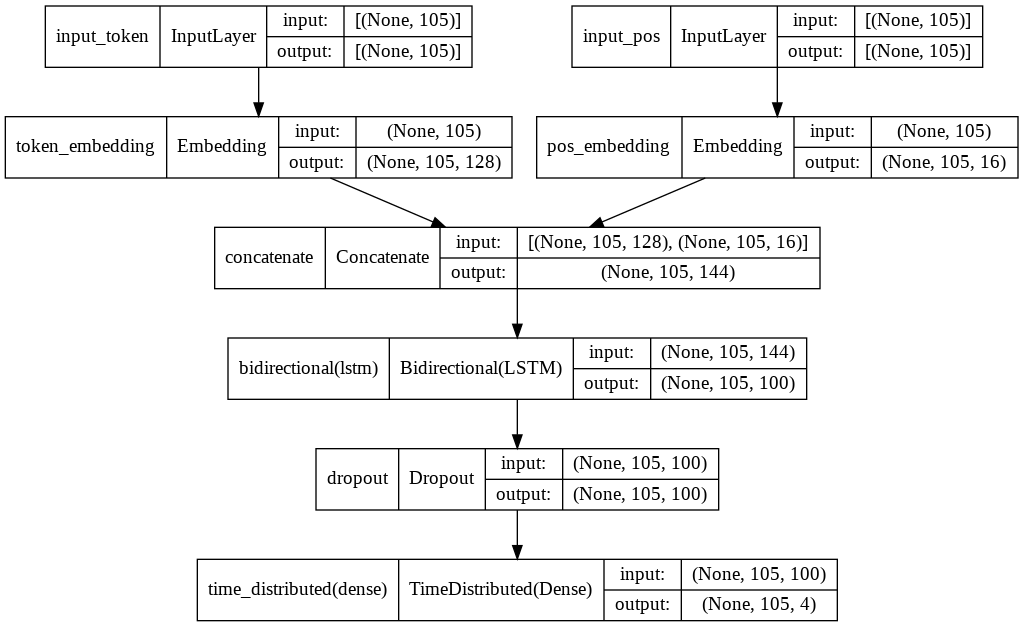

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_pos.png', show_shapes=True)

In [ ]:
# figure out the label distribution in our fixed-length texts
from collections import Counter

all_labs = [l for lab in train_labs_padded for l in lab]
label_count = Counter(all_labs)
total_labs = len(all_labs)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias=[(label_count[0]/total_labs), (label_count[1]/total_labs),
              (label_count[2]/total_labs), (label_count[3]/total_labs)]
print('Initial bias:')
print(initial_bias)

# pass the bias to the model and re-evaluate
model = make_model(output_bias=initial_bias)
results = model.evaluate([X_token, X_pos], y, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Counter({3: 292139, 2: 59095, 0: 1964, 1: 1177})
354375
Initial bias:
[0.005542151675485009, 0.0033213403880070548, 0.1667583774250441, 0.8243781305114638]
Loss: 0.9105


In [ ]:
# prepare the dev sequences, pos and labels as numpy arrays
dev_X_token = np.array(dev_seqs_padded)
dev_X_pos = np.array(dev_pos_padded)
dev_y = np.array(dev_labs_onehot)

# re-initiate model with bias
model = make_model(output_bias=initial_bias)

# and fit...
model.fit([X_token, X_pos], y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=([dev_X_token, dev_X_pos], dev_y))

# save the model
model.save('BiLSTM_PoS.h5')

Epoch 1/100
106/106 [==============================] - 55s 432ms/step - loss: 0.1585 - tp: 315109.0000 - fp: 6825.0000 - tn: 2046357.0000 - fn: 369285.0000 - accuracy: 0.8626 - precision: 0.9788 - recall: 0.4604 - auc: 0.9863 - val_loss: 0.0469 - val_tp: 100511.0000 - val_fp: 1010.0000 - val_tn: 303571.0000 - val_fn: 1016.0000 - val_accuracy: 0.9950 - val_precision: 0.9901 - val_recall: 0.9900 - val_auc: 0.9993
Epoch 2/100
106/106 [==============================] - 44s 413ms/step - loss: 0.0368 - tp: 339466.0000 - fp: 2683.0000 - tn: 1023908.0000 - fn: 2731.0000 - accuracy: 0.9960 - precision: 0.9922 - recall: 0.9920 - auc: 0.9995 - val_loss: 0.0361 - val_tp: 100587.0000 - val_fp: 938.0000 - val_tn: 303643.0000 - val_fn: 940.0000 - val_accuracy: 0.9954 - val_precision: 0.9908 - val_recall: 0.9907 - val_auc: 0.9997
Epoch 3/100
106/106 [==============================] - 43s 409ms/step - loss: 0.0256 - tp: 339501.0000 - fp: 2375.0000 - tn: 1024216.0000 - fn: 2696.0000 - accuracy: 0.9963 -

In [ ]:
# use argmax to figure out the class with highest probability per token
preds = np.argmax(model.predict([dev_seqs_padded, dev_pos_padded]), axis=-1)
flat_preds = [p for pred in preds for p in pred]
print(Counter(flat_preds))

Counter({3: 91627, 2: 12638})


#### Down-weighting

In [ ]:
import copy

def down_weight(labs_onehot, weight=1):
    weights_onehot = copy.deepcopy(labs_onehot)

    # our first-pass class weights: normal for named entities (0 and 1), down-weighted for non named entities (2 and 3)
    class_wts = [1, 1, weight, weight]

    # apply our weights to the label lists
    for i, labs in enumerate(weights_onehot):
        for j, lablist in enumerate(labs):
            lablistaslist = lablist.tolist()
            whichismax = lablistaslist.index(max(lablistaslist))
            weights_onehot[i][j][whichismax] = class_wts[whichismax]
    
    return weights_onehot

In [ ]:
# now try the weighted one-hot encoding
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    train_weights_onehot = down_weight(train_labs_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):', np.shape(y))

    downweight_model = make_model(output_bias=initial_bias)
    downweight_model.fit([X_token, X_pos], y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=([dev_X_token, dev_X_pos], dev_y))

    downweight_models[weight] = downweight_model
    if weight == 1.0:
        downweight_model.save('BiLSTM_PoS.h5')
        print(f'Model saved at BiLSTM_PoS.h5')
    else:
        downweight_model.save(f'BiLSTM_PoS_downweight_{weight}.h5')
        print(f'Model saved at BiLSTM_PoS_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels): (3375, 105, 4)
Epoch 1/100
106/106 [==============================] - 51s 391ms/step - loss: 0.0309 - tp: 307613.0000 - fp: 5008.0000 - tn: 2048174.0000 - fn: 376781.0000 - accuracy: 0.7482 - precision: 0.9840 - recall: 0.4495 - auc: 0.9865 - val_loss: 0.0577 - val_tp: 100446.0000 - val_fp: 852.0000 - val_tn: 303729.0000 - val_fn: 1081.0000 - val_accuracy: 0.9952 - val_precision: 0.9916 - val_recall: 0.9894 - val_auc: 0.9997
Epoch 2/100
106/106 [==============================] - 39s 368ms/step - loss: 0.0142 - tp: 335676.0000 - fp: 1594.0000 - tn: 1024997.0000 - fn: 6521.0000 - accuracy: 0.7491 - precision: 0.9953 - recall: 0.9809 - auc: 0.9998 - val_loss: 0.0321 - val_tp: 100334.0000 - val_fp: 509.0000 - val_tn: 304072.0000 - val_fn: 1193.0000 - val_accuracy: 0.9958 - val_precision: 0.9950 - val_recall: 0.9882 - val_auc: 0.9999
Epoch 3/100
106/106 [==============================] - 39s 370ms/s

In [ ]:
for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict([dev_seqs_padded, dev_pos_padded]), axis=-1)
    flat_preds = [p for pred in preds for p in pred]
    print(f'Weight = {weight}:', Counter(flat_preds))

Weight = 0.1: Counter({3: 91649, 2: 11784, 0: 832})
Weight = 0.2: Counter({3: 91646, 2: 12400, 0: 219})
Weight = 0.3: Counter({3: 91645, 2: 12585, 0: 35})
Weight = 0.4: Counter({3: 91643, 2: 12622})
Weight = 0.5: Counter({3: 91633, 2: 12632})
Weight = 0.6: Counter({3: 91631, 2: 12634})
Weight = 0.7: Counter({3: 91631, 2: 12634})
Weight = 0.8: Counter({3: 91630, 2: 12635})
Weight = 0.9: Counter({3: 91629, 2: 12636})
Weight = 1.0: Counter({3: 91627, 2: 12638})


In [ ]:
def reverse_bio(ind):
    bio = 'O'  # for any pad=3 predictions
    if ind==0:
        bio = 'B'
    elif ind==1:
        bio = 'I'
    elif ind==2:
        bio = 'O'
    return bio

def wnut_evaluate(txt):
    '''entity evaluation: we evaluate by whole named entities'''
    npred = 0; ngold = 0; tp = 0
    nrows = len(txt)
    for i in txt.index:
        if txt['prediction'][i]=='B' and txt['bio_only'][i]=='B':
            npred += 1
            ngold += 1
            for predfindbo in range((i+1),nrows):
                if txt['prediction'][predfindbo]=='O' or txt['prediction'][predfindbo]=='B':
                    break  # find index of first O (end of entity) or B (new entity)
            for goldfindbo in range((i+1),nrows):
                if txt['bio_only'][goldfindbo]=='O' or txt['bio_only'][goldfindbo]=='B':
                    break  # find index of first O (end of entity) or B (new entity)
            if predfindbo==goldfindbo:  # only count a true positive if the whole entity phrase matches
                tp += 1
        elif txt['prediction'][i]=='B':
            npred += 1
        elif txt['bio_only'][i]=='B':
            ngold += 1
  
    fp = npred - tp  # n false predictions
    fn = ngold - tp  # n missing gold entities
    prec = tp / (tp+fp+1e-7)
    rec = tp / (tp+fn+1e-7)
    f1 = (2*(prec*rec)) / (prec+rec+1e-7)
    print('Sum of TP and FP = %i' % (tp+fp))
    print('Sum of TP and FN = %i' % (tp+fn))
    print('True positives = %i, False positives = %i, False negatives = %i' % (tp, fp, fn))
    print('Precision = %.3f, Recall = %.3f, F1 = %.3f' % (prec, rec, f1))

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    preds = np.argmax(downweight_models[weight].predict([dev_seqs_padded, dev_pos_padded]), axis=-1)

    dev_seqs['prediction'] = ''
    for i in dev_seqs.index:
        this_seq_length = len(dev_seqs['token'][i])
        dev_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in dev_long['bio_only']]
    dev_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in dev_long['prediction']]
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Weight = 0.1:
Sum of TP and FP = 832
Sum of TP and FN = 826
True positives = 262, False positives = 570, False negatives = 564
Precision = 0.315, Recall = 0.317, F1 = 0.316

Weight = 0.2:
Sum of TP and FP = 219
Sum of TP and FN = 826
True positives = 49, False positives = 170, False negatives = 777
Precision = 0.224, Recall = 0.059, F1 = 0.094

Weight = 0.3:
Sum of TP and FP = 35
Sum of TP and FN = 826
True positives = 9, False positives = 26, False negatives = 817
Precision = 0.257, Recall = 0.011, F1 = 0.021

Weight = 0.4:
Sum of TP and FP = 0
Sum of TP and FN = 826
True positives = 0, False positives = 0, False negatives = 826
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.5:
Sum of TP and FP = 0
Sum of TP and FN = 826
True positives = 0, False positives = 0, False negatives = 826
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.6:
Sum of TP and FP = 0
Sum of TP and FN = 826
True positives = 0, False positives = 0, False negatives = 826
Precision = 0.000, Recall 

#### Down-sampling

In [ ]:
mask = train_seqs.bio_only.apply(lambda labels: 0.0 in labels)
train_seqs_downsampled = train_seqs[mask]
train_seqs_downsampled.head()

,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 1.0, 6.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....","[4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ..."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46....","[13.0, 11.0, 7.0, 0.0, 9.0, 0.0, 4.0, 9.0, 7.0..."
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0...","[0.0, 2.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, ..."
5,5,"[watching, the, VMA, pre-show, again, lol, it,...","[2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[65.0, 3.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0...","[14.0, 3.0, 9.0, 5.0, 5.0, 13.0, 1.0, 2.0, 15...."


In [ ]:
train_seqs_downsampled_padded = pad_sequences(train_seqs_downsampled['token_indices'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padtok)
train_pos_downsampled_padded = pad_sequences(train_seqs_downsampled['upos_indices'].tolist(), maxlen=seq_length,
                                             dtype='int32', padding='post', truncating='post', value=padpos)
train_labs_downsampled_padded = pad_sequences(train_seqs_downsampled['bio_only'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padlab)
train_labs_downsampled_onehot = [to_categorical(i, num_classes=n_labs) for i in train_labs_downsampled_padded]

# follow the print outputs below to see how the labels are transformed
print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs_downsampled.loc[1])
print('Length of input sequence: %i' % len(train_seqs_downsampled_padded[1]))
print('Length of pos sequence: %i' % len(train_pos_downsampled_padded[1]))
print('Length of label sequence: %i' % len(train_labs_downsampled_onehot[1]))
print(train_labs_downsampled_padded[1][:11])
print(train_pos_downsampled_padded[1][:11])
print(train_labs_downsampled_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
upos_indices     [4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ...
Name: 1, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[2 2 2 2 0 2 2 2 2 2 2]
[4 9 9 8 9 0 0 4 9 9 4]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# figure out the label distribution in our downsampled fixed-length texts
all_labs = [l for lab in train_labs_downsampled_padded for l in lab]
label_count = Counter(all_labs)
total_labs = len(all_labs)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias=[(label_count[0]/total_labs), (label_count[1]/total_labs),
              (label_count[2]/total_labs), (label_count[3]/total_labs)]
print('Initial bias:')
print(initial_bias)

Counter({3: 103017, 2: 22152, 0: 1964, 1: 1177})
128310
Initial bias:
[0.015306679136466371, 0.00917309640713896, 0.17264437689969606, 0.8028758475566986]


In [ ]:
# prepare sequences and labels as numpy arrays, check dimensions
X_token = np.array(train_seqs_downsampled_padded)
X_pos = np.array(train_pos_downsampled_padded)
y = np.array(train_labs_downsampled_onehot)
print('Input token sequence dimensions (n.docs, seq.length):')
print(X_token.shape)
print('Input pos sequence dimensions (n.docs, seq.length):')
print(X_pos.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):')
print(y.shape)

Input token sequence dimensions (n.docs, seq.length):
(1222, 105)
Input pos sequence dimensions (n.docs, seq.length):
(1222, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):
(1222, 105, 4)


In [ ]:
# now try the weighted one-hot encoding
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    train_weights_onehot = down_weight(train_labs_downsampled_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels):', np.shape(y))

    downweight_model = make_model(output_bias=initial_bias)
    downweight_model.fit([X_token, X_pos], y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=([dev_X_token, dev_X_pos], dev_y))

    downweight_models[weight] = downweight_model
    if weight == 1.0:
        downweight_model.save('BiLSTM_PoS_downsampled.h5')
        print(f'Model saved at BiLSTM_PoS_downsampled.h5')
    else:
        downweight_model.save(f'BiLSTM_PoS_downsampled_downweight_{weight}.h5')
        print(f'Model saved at BiLSTM_PoS_downsampled_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 4 NER labels): (1222, 105, 4)
Epoch 1/100
39/39 [==============================] - 32s 476ms/step - loss: 0.0715 - tp: 266672.0000 - fp: 5790.0000 - tn: 980592.0000 - fn: 62122.0000 - accuracy: 0.8220 - precision: 0.9787 - recall: 0.8111 - auc: 0.9904 - val_loss: 0.1505 - val_tp: 87339.0000 - val_fp: 10.0000 - val_tn: 304571.0000 - val_fn: 14188.0000 - val_accuracy: 0.9650 - val_precision: 0.9999 - val_recall: 0.8603 - val_auc: 0.9989
Epoch 2/100
39/39 [==============================] - 16s 417ms/step - loss: 0.0410 - tp: 105693.0000 - fp: 1081.0000 - tn: 369842.0000 - fn: 17948.0000 - accuracy: 0.7480 - precision: 0.9899 - recall: 0.8548 - auc: 0.9962 - val_loss: 0.1146 - val_tp: 90228.0000 - val_fp: 18.0000 - val_tn: 304563.0000 - val_fn: 11299.0000 - val_accuracy: 0.9721 - val_precision: 0.9998 - val_recall: 0.8887 - val_auc: 0.9988
Epoch 3/100
39/39 [==============================] - 16s 412ms/step - loss

In [ ]:
for weight in [1.0, .9, .8, .7, .6, .5, .4, .3, .2, .1]:
    preds = np.argmax(downweight_models[weight].predict([dev_seqs_padded, dev_pos_padded]), axis=-1)

    dev_seqs['prediction'] = ''
    for i in dev_seqs.index:
        this_seq_length = len(dev_seqs['token'][i])
        dev_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in dev_long['bio_only']]
    dev_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in dev_long['prediction']]
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Weight = 1.0:
Sum of TP and FP = 0
Sum of TP and FN = 826
True positives = 0, False positives = 0, False negatives = 826
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 0
Sum of TP and FN = 826
True positives = 0, False positives = 0, False negatives = 826
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 3
Sum of TP and FN = 826
True positives = 0, False positives = 3, False negatives = 826
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.7:
Sum of TP and FP = 26
Sum of TP and FN = 826
True positives = 5, False positives = 21, False negatives = 821
Precision = 0.192, Recall = 0.006, F1 = 0.012

Weight = 0.6:
Sum of TP and FP = 73
Sum of TP and FN = 826
True positives = 9, False positives = 64, False negatives = 817
Precision = 0.123, Recall = 0.011, F1 = 0.020

Weight = 0.5:
Sum of TP and FP = 156
Sum of TP and FN = 826
True positives = 25, False positives = 131, False negatives = 801
Precision = 0.160, Recall = 0.

#### Merging B and I labels

In [ ]:
# training labels: convert BIO to integers, this time merging B and I
def bo_index(bio):
    ind = bio
    if not pd.isnull(bio):  # deal with empty lines
        if bio == 'B' or bio =='I':
            ind = 0
        elif bio == 'O':
            ind = 1
    return ind

# pass a data frame through the new feature extractor
def extract_features_pos_bo(txt, istest=False):
    txt_copy = txt.copy()
    tokinds = [token_index(u) for u in txt_copy['token']]
    txt_copy['token_indices'] = tokinds
    posinds = [pos_index(p) for p in txt_copy['upos']]
    txt_copy['upos_indices'] = posinds
    if not istest:  # can't do this with the test set
        boints = [bo_index(b) for b in txt_copy['bio_only']]
        txt_copy['bio_only'] = boints
    return txt_copy

train_copy_bo = extract_features_pos_bo(train)
train_copy_bo.head(n=30)

,token,label,bio_only,upos,token_indices,upos_indices
0,@paulwalk,O,1.0,NOUN,0.0,0.0
1,It,O,1.0,PRON,1.0,1.0
2,'s,O,1.0,AUX,2.0,2.0
3,the,O,1.0,DET,3.0,3.0
4,view,O,1.0,NOUN,4.0,0.0
5,from,O,1.0,ADP,5.0,4.0
6,where,O,1.0,ADV,6.0,5.0
7,I,O,1.0,PRON,7.0,1.0
8,'m,O,1.0,X,8.0,6.0
9,living,O,1.0,NOUN,9.0,0.0


In [ ]:
print("This cell takes a little while to run: be patient :)")
train_seqs_bo = tokens2sequences_pos(train_copy_bo)
train_seqs_bo.head()

This cell takes a little while to run: be patient :)


,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 1.0, 6.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....","[4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ..."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46....","[13.0, 11.0, 7.0, 0.0, 9.0, 0.0, 4.0, 9.0, 7.0..."
3,3,"[today, is, my, last, day, at, the, office, .]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[51.0, 52.0, 53.0, 23.0, 54.0, 55.0, 3.0, 56.0...","[0.0, 2.0, 1.0, 11.0, 0.0, 4.0, 3.0, 0.0, 8.0]"
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0...","[0.0, 2.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# process the dev set
wnutdev = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17dev_clean_tagged.txt'
dev = pd.read_table(wnutdev, header=None, names=['token', 'label', 'bio_only', 'upos'])
dev_copy_bo = extract_features_pos_bo(dev)
dev_seqs_bo = tokens2sequences_pos(dev_copy_bo)
dev_seqs_bo.head()

,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[Stabilized, approach, or, not, ?, That, ´, s,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 10361.0, 414.0, 556.0, 131.0, 1740.0...","[9.0, 0.0, 16.0, 15.0, 8.0, 1.0, 10.0, 15.0, 1..."
1,1,"[You, should, ', ve, stayed, on, Redondo, Beac...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[151.0, 1018.0, 573.0, 12927.0, 9346.0, 137.0,...","[1.0, 2.0, 8.0, 0.0, 14.0, 4.0, 9.0, 9.0, 9.0,..."
2,2,"[All, I, ', ve, been, doing, is, BINGE, watchi...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...","[3.0, 1.0, 8.0, 0.0, 2.0, 14.0, 2.0, 9.0, 14.0..."
3,3,"[wow, emma, and, kaite, is, so, very, cute, an...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[4777.0, 14801.0, 113.0, 14801.0, 52.0, 79.0, ...","[13.0, 0.0, 16.0, 0.0, 2.0, 5.0, 5.0, 11.0, 16..."
4,4,"[THIS, IS, SO, GOOD]","[1.0, 1.0, 1.0, 1.0]","[2239.0, 1567.0, 1089.0, 9176.0]","[3.0, 2.0, 5.0, 11.0]"


In [ ]:
# process the 2-class training set: padding the tokens, pos and labels, and one-hot encoding the labels
train_seqs_bo_padded = pad_sequences(train_seqs_bo['token_indices'].tolist(), maxlen=seq_length,
                                     dtype='int32', padding='post', truncating='post', value=padtok)
train_pos_bo_padded = pad_sequences(train_seqs_bo['upos_indices'].tolist(), maxlen=seq_length,
                                    dtype='int32', padding='post', truncating='post', value=padpos)
padlab_bo = 2
train_labs_bo_padded = pad_sequences(train_seqs_bo['bio_only'].tolist(), maxlen=seq_length,
                                     dtype='int32', padding='post', truncating='post', value=padlab_bo)
n_labs_bo = 3
train_labs_bo_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in train_labs_bo_padded]

print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs_bo.loc[1])
print('Length of input sequence: %i' % len(train_seqs_bo_padded[1]))
print('Length of pos sequence: %i' % len(train_pos_bo_padded[1]))
print('Length of label sequence: %i' % len(train_labs_bo_onehot[1]))
print(train_pos_bo_padded[1][:11])
print(train_labs_bo_padded[1][:11])
print(train_labs_bo_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
upos_indices     [4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ...
Name: 1, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[4 9 9 8 9 0 0 4 9 9 4]
[1 1 1 1 0 1 1 1 1 1 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# now process the 2-class dev set in the same way: padding the tokens, pos and labels, and one-hot encoding the labels
dev_seqs_bo_padded = pad_sequences(dev_seqs_bo['token_indices'].tolist(), maxlen=seq_length,
                                   dtype='int32', padding='post', truncating='post', value=padtok)
dev_pos_bo_padded = pad_sequences(dev_seqs_bo['upos_indices'].tolist(), maxlen=seq_length,
                                  dtype='int32', padding='post', truncating='post', value=padpos)
dev_labs_bo_padded = pad_sequences(dev_seqs_bo['bio_only'].tolist(), maxlen=seq_length,
                                   dtype='int32', padding='post', truncating='post', value=padlab_bo)
dev_labs_bo_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in dev_labs_bo_padded]

print('Dev set padded label sequence and one-hot encoding (first 10 tokens):')
print(dev_seqs_bo.loc[2])
print('Length of input sequence: %i' % len(dev_seqs_bo_padded[1]))
print('Length of pos sequence: %i' % len(dev_pos_bo_padded[1]))
print('Length of label sequence: %i' % len(dev_labs_bo_onehot[1]))
print(dev_pos_bo_padded[2][:11])
print(dev_labs_bo_padded[2][:11])
print(dev_labs_bo_onehot[2][:11])

Dev set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     2
token            [All, I, ', ve, been, doing, is, BINGE, watchi...
bio_only         [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [405.0, 7.0, 573.0, 12927.0, 90.0, 848.0, 52.0...
upos_indices     [3.0, 1.0, 8.0, 0.0, 2.0, 14.0, 2.0, 9.0, 14.0...
Name: 2, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[ 3  1  8  0  2 14  2  9 14  9 16]
[1 1 1 1 1 1 1 1 1 0 0]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [ ]:
all_labs_bo = [l for lab in train_labs_bo_padded for l in lab]
label_count = Counter(all_labs_bo)
total_labs = len(all_labs_bo)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias = [(label_count[0]/total_labs), (label_count[1]/total_labs), (label_count[2]/total_labs)]
print('Initial bias:')
print(initial_bias)

Counter({2: 292139, 1: 59095, 0: 3141})
354375
Initial bias:
[0.008863492063492063, 0.1667583774250441, 0.8243781305114638]


In [ ]:
# prepare sequences and labels as numpy arrays, check dimensions
X_token = np.array(train_seqs_bo_padded)
X_pos = np.array(train_pos_bo_padded)
y = np.array(train_labs_bo_onehot)
print('Input token sequence dimensions (n.docs, seq.length):')
print(X_token.shape)
print('Input pos sequence dimensions (n.docs, seq.length):')
print(X_pos.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):')
print(y.shape)


# use the same model, with the only difference in the output dimensions
def make_model_bo(metrics=METRICS, output_bias=None, seed=42):
    init_random_seed(seed)
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    token = keras.layers.Input(shape=(seq_length,), name='input_token')
    pos = keras.layers.Input(shape=(seq_length,), name='input_pos')
    embed_token = keras.layers.Embedding(input_dim=vocab_size, output_dim=token_embed_size, input_length=seq_length, mask_zero=True, trainable=True, name='token_embedding')(token)
    embed_pos = keras.layers.Embedding(input_dim=pos_size, output_dim=pos_embed_size, input_length=seq_length, mask_zero=True, trainable=True, name='pos_embedding')(pos)
    concat = keras.layers.Concatenate()([embed_token, embed_pos])
    biLSTM = keras.layers.Bidirectional(keras.layers.LSTM(units=50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(concat)  # 2 directions, 50 units each, concatenated (can change this)
    dropout = keras.layers.Dropout(0.5)(biLSTM)
    dense = keras.layers.TimeDistributed(keras.layers.Dense(n_labs_bo, activation='softmax', bias_initializer=output_bias))(dropout)
    model = keras.Model(inputs=[token, pos], outputs=dense)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy(), metrics=metrics)
    return model

print('**Defining a neural network**')
# pass the bias to the model and re-evaluate
model = make_model_bo(output_bias=initial_bias)
model.summary()

Input token sequence dimensions (n.docs, seq.length):
(3375, 105)
Input pos sequence dimensions (n.docs, seq.length):
(3375, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):
(3375, 105, 3)
**Defining a neural network**
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 105)]        0           []                               
                                                                                                  
 input_pos (InputLayer)         [(None, 105)]        0           []                               
                                                                                                  
 token_embedding (Embedding)    (None, 105, 128)     1894784     ['input_token[0][0]']            
                                          

In [ ]:
# now try the weighted one-hot encoding
def down_weight_bo(labs_onehot, weight=1):
    weights_onehot = copy.deepcopy(labs_onehot)

    # our first-pass class weights: normal for named entities (0), down-weighted for non named entities (1 and 2)
    class_wts = [1, weight, weight]

    # apply our weights to the label lists
    for i, labs in enumerate(weights_onehot):
        for j, lablist in enumerate(labs):
            lablistaslist = lablist.tolist()
            whichismax = lablistaslist.index(max(lablistaslist))
            weights_onehot[i][j][whichismax] = class_wts[whichismax]
    
    return weights_onehot

In [ ]:
# prepare the dev sequences, pos and labels as numpy arrays
dev_X_token = np.array(dev_seqs_bo_padded)
dev_X_pos = np.array(dev_pos_bo_padded)
dev_y = np.array(dev_labs_bo_onehot)

In [ ]:
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    train_weights_onehot = down_weight_bo(train_labs_bo_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):', np.shape(y))

    downweight_model = make_model_bo(output_bias=initial_bias)
    downweight_model.fit([X_token, X_pos], y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=([dev_X_token, dev_X_pos], dev_y))

    downweight_models[weight] = downweight_model
    if weight == 1.0:
        downweight_model.save('BiLSTM_PoS_2class.h5')
        print(f'Model saved at BiLSTM_PoS_2class.h5')
    else:
        downweight_model.save(f'BiLSTM_PoS_2class_downweight_{weight}.h5')
        print(f'Model saved at BiLSTM_PoS_2class_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels): (3375, 105, 3)
Epoch 1/100
106/106 [==============================] - 49s 387ms/step - loss: 0.0243 - tp: 519359.0000 - fp: 23658.0000 - tn: 1198967.0000 - fn: 41190.0000 - accuracy: 0.7128 - precision: 0.9564 - recall: 0.9265 - auc: 0.9947 - val_loss: 0.0486 - val_tp: 100480.0000 - val_fp: 886.0000 - val_tn: 202168.0000 - val_fn: 1047.0000 - val_accuracy: 0.9937 - val_precision: 0.9913 - val_recall: 0.9897 - val_auc: 0.9998
Epoch 2/100
106/106 [==============================] - 39s 371ms/step - loss: 0.0082 - tp: 336878.0000 - fp: 4545.0000 - tn: 679849.0000 - fn: 5319.0000 - accuracy: 0.6641 - precision: 0.9867 - recall: 0.9845 - auc: 0.9996 - val_loss: 0.0246 - val_tp: 100694.0000 - val_fp: 740.0000 - val_tn: 202314.0000 - val_fn: 833.0000 - val_accuracy: 0.9948 - val_precision: 0.9927 - val_recall: 0.9918 - val_auc: 0.9999
Epoch 3/100
106/106 [==============================] - 39s 372ms/ste

In [ ]:
def reverse_bo(ind):
    bo = 'O'  # for any pad=2 predictions
    if ind == 0:
        bo = 'B'
    elif ind == 1:
        bo = 'O'
    return bo

def reverse_bio_from_bo(inds):
    bo = [reverse_bo(i) for i in inds]
    bio = copy.deepcopy(bo)
    for i in range(len(bo)):
        if i >= 1 and bo[i] == 'B' and bo[i - 1] == 'B':
            bio[i] = 'I'
    return bio

In [ ]:
for weight in [1.0, .9, .8, .7, .6, .5, .4, .3, .2, .1]:
    preds = np.argmax(downweight_models[weight].predict([dev_seqs_bo_padded, dev_pos_bo_padded]), axis=-1)

    dev_seqs_bo['prediction'] = ''
    for i in dev_seqs_bo.index:
        this_seq_length = len(dev_seqs_bo['token'][i])
        dev_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(dev_long['bio_only'])
    dev_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(dev_long['prediction'])
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Weight = 1.0:
Sum of TP and FP = 0
Sum of TP and FN = 805
True positives = 0, False positives = 0, False negatives = 805
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 0
Sum of TP and FN = 805
True positives = 0, False positives = 0, False negatives = 805
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 0
Sum of TP and FN = 805
True positives = 0, False positives = 0, False negatives = 805
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.7:
Sum of TP and FP = 1
Sum of TP and FN = 805
True positives = 0, False positives = 1, False negatives = 805
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.6:
Sum of TP and FP = 12
Sum of TP and FN = 805
True positives = 2, False positives = 10, False negatives = 803
Precision = 0.167, Recall = 0.002, F1 = 0.005

Weight = 0.5:
Sum of TP and FP = 46
Sum of TP and FN = 805
True positives = 10, False positives = 36, False negatives = 795
Precision = 0.217, Recall = 0.012,

#### Merging B and I labels, with down-sampling

In [ ]:
mask = train_seqs.bio_only.apply(lambda labels: 0.0 in labels)
train_seqs_downsampled = train_seqs_bo[mask]
train_seqs_downsampled.head()

,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[@paulwalk, It, 's, the, view, from, where, I,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 0.0, 4.0, 5.0, 1.0, 6.0, ..."
1,1,"[From, Green, Newsfeed, :, AHFA, extends, dead...","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...","[26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....","[4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ..."
2,2,"[Pxleyes, Top, 50, Photography, Contest, Pictu...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46....","[13.0, 11.0, 7.0, 0.0, 9.0, 0.0, 4.0, 9.0, 7.0..."
4,4,"[4Dbling, 's, place, til, monday, ,, party, pa...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[57.0, 2.0, 58.0, 59.0, 60.0, 61.0, 62.0, 62.0...","[0.0, 2.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, ..."
5,5,"[watching, the, VMA, pre-show, again, lol, it,...","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[65.0, 3.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0...","[14.0, 3.0, 9.0, 5.0, 5.0, 13.0, 1.0, 2.0, 15...."


In [ ]:
train_seqs_downsampled_padded = pad_sequences(train_seqs_downsampled['token_indices'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padtok)
train_pos_downsampled_padded = pad_sequences(train_seqs_downsampled['upos_indices'].tolist(), maxlen=seq_length,
                                             dtype='int32', padding='post', truncating='post', value=padpos)
train_labs_downsampled_padded = pad_sequences(train_seqs_downsampled['bio_only'].tolist(), maxlen=seq_length,
                                              dtype='int32', padding='post', truncating='post', value=padlab_bo)
train_labs_downsampled_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in train_labs_downsampled_padded]

# follow the print outputs below to see how the labels are transformed
print('Example of padded label sequence and one-hot encoding (first 10 tokens):')
print(train_seqs_downsampled.loc[1])
print('Length of input sequence: %i' % len(train_seqs_downsampled_padded[1]))
print('Length of pos sequence: %i' % len(train_pos_downsampled_padded[1]))
print('Length of label sequence: %i' % len(train_labs_downsampled_onehot[1]))
print(train_labs_downsampled_padded[1][:11])
print(train_pos_downsampled_padded[1][:11])
print(train_labs_downsampled_onehot[1][:11])

Example of padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     1
token            [From, Green, Newsfeed, :, AHFA, extends, dead...
bio_only         [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 10....
upos_indices     [4.0, 9.0, 9.0, 8.0, 9.0, 0.0, 0.0, 4.0, 9.0, ...
Name: 1, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[1 1 1 1 0 1 1 1 1 1 1]
[4 9 9 8 9 0 0 4 9 9 4]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# figure out the label distribution in our downsampled fixed-length texts
all_labs = [l for lab in train_labs_downsampled_padded for l in lab]
label_count = Counter(all_labs)
total_labs = len(all_labs)
print(label_count)
print(total_labs)

# use this to define an initial model bias
initial_bias = [(label_count[0]/total_labs), (label_count[1]/total_labs), (label_count[2]/total_labs)]
print('Initial bias:')
print(initial_bias)

Counter({2: 103017, 1: 22152, 0: 3141})
128310
Initial bias:
[0.02447977554360533, 0.17264437689969606, 0.8028758475566986]


In [ ]:
# prepare sequences and labels as numpy arrays, check dimensions
X_token = np.array(train_seqs_downsampled_padded)
X_pos = np.array(train_pos_downsampled_padded)
y = np.array(train_labs_downsampled_onehot)
print('Input token sequence dimensions (n.docs, seq.length):')
print(X_token.shape)
print('Input pos sequence dimensions (n.docs, seq.length):')
print(X_pos.shape)
print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):')
print(y.shape)

Input token sequence dimensions (n.docs, seq.length):
(1222, 105)
Input pos sequence dimensions (n.docs, seq.length):
(1222, 105)
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):
(1222, 105, 3)


In [ ]:
# now try the weighted one-hot encoding
downweight_models = {}

for weight in [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]:
    train_weights_onehot = down_weight_bo(train_labs_downsampled_onehot, weight)
    y = np.array(train_weights_onehot)
    print('Down-weighting:', weight)
    print('Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels):', np.shape(y))

    downweight_model = make_model_bo(output_bias=initial_bias)
    downweight_model.fit([X_token, X_pos], y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks = [early_stopping], validation_data=([dev_X_token, dev_X_pos], dev_y))

    downweight_models[weight] = downweight_model
    if weight == 1.0:
        downweight_model.save('BiLSTM_PoS_2class_downsampled.h5')
        print(f'Model saved at BiLSTM_PoS_2class_downsampled.h5')
    else:
        downweight_model.save(f'BiLSTM_PoS_2class_downsampled_downweight_{weight}.h5')
        print(f'Model saved at BiLSTM_PoS_2class_downsampled_downweight_{weight}.h5')
    print()

Down-weighting: 0.1
Label dimensions (n.docs, seq.length, one-hot encoding of 3 NER labels): (1222, 105, 3)
Epoch 1/100
39/39 [==============================] - 26s 464ms/step - loss: 0.0563 - tp: 102436.0000 - fp: 10324.0000 - tn: 1263549.0000 - fn: 363402.0000 - accuracy: 0.7206 - precision: 0.9084 - recall: 0.2199 - auc: 0.9715 - val_loss: 0.1361 - val_tp: 88669.0000 - val_fp: 7503.0000 - val_tn: 195551.0000 - val_fn: 12858.0000 - val_accuracy: 0.9332 - val_precision: 0.9220 - val_recall: 0.8734 - val_auc: 0.9926
Epoch 2/100
39/39 [==============================] - 16s 418ms/step - loss: 0.0255 - tp: 108843.0000 - fp: 11156.0000 - tn: 236126.0000 - fn: 14798.0000 - accuracy: 0.6420 - precision: 0.9070 - recall: 0.8803 - auc: 0.9901 - val_loss: 0.1069 - val_tp: 91613.0000 - val_fp: 8185.0000 - val_tn: 194869.0000 - val_fn: 9914.0000 - val_accuracy: 0.9406 - val_precision: 0.9180 - val_recall: 0.9024 - val_auc: 0.9941
Epoch 3/100
39/39 [==============================] - 16s 421ms/step

In [ ]:
for weight in [1.0, .9, .8, .7, .6, .5, .4, .3, .2, .1]:
    preds = np.argmax(downweight_models[weight].predict([dev_seqs_bo_padded, dev_pos_bo_padded]), axis=-1)

    dev_seqs_bo['prediction'] = ''
    for i in dev_seqs_bo.index:
        this_seq_length = len(dev_seqs_bo['token'][i])
        dev_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    dev_long = dev_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(dev_long['bio_only'])
    dev_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(dev_long['prediction'])
    dev_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(dev_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Weight = 1.0:
Sum of TP and FP = 69
Sum of TP and FN = 805
True positives = 12, False positives = 57, False negatives = 793
Precision = 0.174, Recall = 0.015, F1 = 0.027

Weight = 0.9:
Sum of TP and FP = 113
Sum of TP and FN = 805
True positives = 21, False positives = 92, False negatives = 784
Precision = 0.186, Recall = 0.026, F1 = 0.046

Weight = 0.8:
Sum of TP and FP = 171
Sum of TP and FN = 805
True positives = 47, False positives = 124, False negatives = 758
Precision = 0.275, Recall = 0.058, F1 = 0.096

Weight = 0.7:
Sum of TP and FP = 224
Sum of TP and FN = 805
True positives = 66, False positives = 158, False negatives = 739
Precision = 0.295, Recall = 0.082, F1 = 0.128

Weight = 0.6:
Sum of TP and FP = 333
Sum of TP and FN = 805
True positives = 110, False positives = 223, False negatives = 695
Precision = 0.330, Recall = 0.137, F1 = 0.193

Weight = 0.5:
Sum of TP and FP = 479
Sum of TP and FN = 805
True positives = 187, False positives = 292, False negatives = 618
Precision 

### 5. Evaluation on the test set

In [ ]:
# process the annotated test set
wnuttest_annot = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17test_annotated_clean_tagged.txt'
test_annot = pd.read_table(wnuttest_annot, header=None, names=['token', 'label', 'bio_only', 'upos'])
test_annot_copy = extract_features(test_annot)
test_annot_seqs = tokens2sequences(test_annot_copy)
test_annot_longest = find_longest_sequence(test_annot_seqs, 0)
assert test_annot_longest == test_longest
print('The longest sequence in the test set is %i tokens long' % test_annot_longest)

The longest sequence in the test set is 105 tokens long


In [ ]:
# pad the tokens & labels, and one-hot encode the labels for the test set
test_seqs_padded = pad_sequences(test_annot_seqs['token_indices'].tolist(), maxlen=seq_length,
                                 dtype='int32', padding='post', truncating='post', value=padtok)
test_labs_padded = pad_sequences(test_annot_seqs['bio_only'].tolist(), maxlen=seq_length,
                                 dtype='int32', padding='post', truncating='post', value=padlab)
test_labs_onehot = [to_categorical(i, num_classes=n_labs) for i in test_labs_padded]

print('Test set padded label sequence and one-hot encoding (first 10 tokens):')
print(test_annot_seqs.loc[4])
print('Length of input sequence: %i' % len(test_seqs_padded[1]))
print('Length of label sequence: %i' % len(test_labs_onehot[1]))
print(test_labs_padded[4][:11])
print(test_labs_onehot[4][:11])

Test set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     4
token            [The, bodies, of, the, soldiers, were, recover...
bio_only         [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14...
prediction       [0, 1, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 1, ...
Name: 4, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[2 2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# 2-class test set
test_annot_copy_bo = extract_features_bo(test_annot)
test_annot_seqs_bo = tokens2sequences(test_annot_copy_bo)
test_annot_seqs_bo.head()

,sequence_num,token,bio_only,token_indices
0,0,"[&, gt, ;, *, The, soldier, was, killed, when,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 1480..."
1,1,"[&, gt, ;, *, Police, last, week, evacuated, 8...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 14801.0, 23..."
2,2,"[&, gt, ;, *, The, army, on, Thursday, recover...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 1480..."
3,3,"[&, gt, ;, *, The, four, civilians, killed, in...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 4012..."
4,4,"[The, bodies, of, the, soldiers, were, recover...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14..."


In [ ]:
# now process the 2-class test set in the same way: padding the tokens & labels, and one-hot encoding the labels
test_seqs_bo_padded = pad_sequences(test_annot_seqs_bo['token_indices'].tolist(), maxlen=seq_length,
                                    dtype='int32', padding='post', truncating='post', value=padtok)
test_labs_bo_padded = pad_sequences(test_annot_seqs_bo['bio_only'].tolist(), maxlen=seq_length,
                                    dtype='int32', padding='post', truncating='post', value=padlab_bo)
test_labs_bo_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in test_labs_bo_padded]

print('Test set padded label sequence and one-hot encoding (first 10 tokens):')
print(test_annot_seqs_bo.loc[4])
print('Length of input sequence: %i' % len(test_seqs_bo_padded[1]))
print('Length of label sequence: %i' % len(test_labs_bo_onehot[1]))
print(test_labs_bo_padded[4][:11])
print(test_labs_bo_onehot[4][:11])

Test set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     4
token            [The, bodies, of, the, soldiers, were, recover...
bio_only         [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14...
Name: 4, dtype: object
Length of input sequence: 105
Length of label sequence: 105
[1 1 1 1 1 1 1 1 1 1 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# test set with pos
wnuttest_annot = 'https://storage.googleapis.com/wnut-2017_ner-shared-task/wnut17test_annotated_clean_tagged.txt'
test_annot = pd.read_table(wnuttest_annot, header=None, names=['token', 'label', 'bio_only', 'upos'])
test_annot_copy = extract_features_pos(test_annot)
test_annot_seqs = tokens2sequences_pos(test_annot_copy)
test_annot_seqs.head()

,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[&, gt, ;, *, The, soldier, was, killed, when,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 1480...","[16.0, 6.0, 8.0, 8.0, 3.0, 11.0, 2.0, 14.0, 5...."
1,1,"[&, gt, ;, *, Police, last, week, evacuated, 8...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 14801.0, 23...","[16.0, 6.0, 8.0, 8.0, 0.0, 11.0, 0.0, 14.0, 7...."
2,2,"[&, gt, ;, *, The, army, on, Thursday, recover...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 1480...","[16.0, 6.0, 8.0, 8.0, 3.0, 0.0, 4.0, 9.0, 14.0..."
3,3,"[&, gt, ;, *, The, four, civilians, killed, in...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 4012...","[16.0, 6.0, 8.0, 8.0, 3.0, 7.0, 0.0, 14.0, 14...."
4,4,"[The, bodies, of, the, soldiers, were, recover...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14...","[3.0, 0.0, 4.0, 3.0, 0.0, 2.0, 14.0, 5.0, 3.0,..."


In [ ]:
# pad the tokens, pos and labels, and one-hot encode the labels
test_seqs_padded = pad_sequences(test_annot_seqs['token_indices'].tolist(), maxlen=seq_length,
                                 dtype='int32', padding='post', truncating='post', value=padtok)
test_pos_padded = pad_sequences(test_annot_seqs['upos_indices'].tolist(), maxlen=seq_length,
                                dtype='int32', padding='post', truncating='post', value=padpos)
test_labs_padded = pad_sequences(test_annot_seqs['bio_only'].tolist(), maxlen=seq_length,
                                 dtype='int32', padding='post', truncating='post', value=padlab)
test_labs_onehot = [to_categorical(i, num_classes=n_labs) for i in test_labs_padded]

print('Test set padded label sequence and one-hot encoding (first 10 tokens):')
print(test_annot_seqs.loc[4])
print('Length of input sequence: %i' % len(test_seqs_padded[1]))
print('Length of pos sequence: %i' % len(test_pos_padded[1]))
print('Length of label sequence: %i' % len(test_labs_onehot[1]))
print(test_pos_padded[4][:11])
print(test_labs_padded[4][:11])
print(test_labs_onehot[4][:11])

Test set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     4
token            [The, bodies, of, the, soldiers, were, recover...
bio_only         [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
token_indices    [191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14...
upos_indices     [3.0, 0.0, 4.0, 3.0, 0.0, 2.0, 14.0, 5.0, 3.0,...
Name: 4, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[ 3  0  4  3  0  2 14  5  3 11  0]
[2 2 2 2 2 2 2 2 2 2 2]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [ ]:
# 2-class test set with pos
test_annot_copy_bo = extract_features_pos_bo(test_annot)
test_annot_seqs_bo = tokens2sequences_pos(test_annot_copy_bo)
test_annot_seqs_bo.head()

,sequence_num,token,bio_only,token_indices,upos_indices
0,0,"[&, gt, ;, *, The, soldier, was, killed, when,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 1480...","[16.0, 6.0, 8.0, 8.0, 3.0, 11.0, 2.0, 14.0, 5...."
1,1,"[&, gt, ;, *, Police, last, week, evacuated, 8...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 14801.0, 23...","[16.0, 6.0, 8.0, 8.0, 0.0, 11.0, 0.0, 14.0, 7...."
2,2,"[&, gt, ;, *, The, army, on, Thursday, recover...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 1480...","[16.0, 6.0, 8.0, 8.0, 3.0, 0.0, 4.0, 9.0, 14.0..."
3,3,"[&, gt, ;, *, The, four, civilians, killed, in...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[14801.0, 14801.0, 1625.0, 1743.0, 191.0, 4012...","[16.0, 6.0, 8.0, 8.0, 3.0, 7.0, 0.0, 14.0, 14...."
4,4,"[The, bodies, of, the, soldiers, were, recover...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14...","[3.0, 0.0, 4.0, 3.0, 0.0, 2.0, 14.0, 5.0, 3.0,..."


In [ ]:
# now process the 2-class test set in the same way: padding the tokens, pos and labels, and one-hot encoding the labels
test_seqs_bo_padded = pad_sequences(test_annot_seqs_bo['token_indices'].tolist(), maxlen=seq_length,
                                    dtype='int32', padding='post', truncating='post', value=padtok)
test_pos_bo_padded = pad_sequences(test_annot_seqs_bo['upos_indices'].tolist(), maxlen=seq_length,
                                   dtype='int32', padding='post', truncating='post', value=padpos)
test_labs_bo_padded = pad_sequences(test_annot_seqs_bo['bio_only'].tolist(), maxlen=seq_length,
                                    dtype='int32', padding='post', truncating='post', value=padlab_bo)
test_labs_bo_onehot = [to_categorical(i, num_classes=n_labs_bo) for i in test_labs_bo_padded]

print('Test set padded label sequence and one-hot encoding (first 10 tokens):')
print(test_annot_seqs_bo.loc[4])
print('Length of input sequence: %i' % len(test_seqs_bo_padded[1]))
print('Length of pos sequence: %i' % len(test_pos_bo_padded[1]))
print('Length of label sequence: %i' % len(test_labs_bo_onehot[1]))
print(test_pos_bo_padded[4][:11])
print(test_labs_bo_padded[4][:11])
print(test_labs_bo_onehot[4][:11])

Test set padded label sequence and one-hot encoding (first 10 tokens):
sequence_num                                                     4
token            [The, bodies, of, the, soldiers, were, recover...
bio_only         [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
token_indices    [191.0, 14801.0, 45.0, 3.0, 14801.0, 225.0, 14...
upos_indices     [3.0, 0.0, 4.0, 3.0, 0.0, 2.0, 14.0, 5.0, 3.0,...
Name: 4, dtype: object
Length of input sequence: 105
Length of pos sequence: 105
Length of label sequence: 105
[ 3  0  4  3  0  2 14  5  3 11  0]
[1 1 1 1 1 1 1 1 1 1 1]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# BiLSTM
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_downweight_{weight}.h5')

    preds = np.argmax(model.predict(test_seqs_padded), axis=-1)

    test_annot_seqs['prediction'] = ''
    for i in test_annot_seqs.index:
        this_seq_length = len(test_annot_seqs['token'][i])
        test_annot_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in test_long['bio_only']]
    test_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in test_long['prediction']]
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 3
Sum of TP and FN = 1076
True positives = 0, False positives = 3, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 8
Sum of TP and FN = 1076
True positives = 0, False positives = 8, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 14
Sum of TP and FN = 1076
True positives = 1, False positives = 13, False negatives = 1075
Precision = 0.071, Recall = 0.001, F1 = 0.002

Weight = 0.7:
Sum of TP and FP = 24
Sum of TP and FN = 1076
True positives = 2, False positives = 22, False negatives = 1074
Precision = 0.083, Recall = 0.002, F1 = 0.004

Weight = 0.6:
Sum of TP and FP = 47
Sum of TP and FN = 1076
True positives = 3, False positives = 44, False negatives = 1073
Precision = 0.064, Recall = 0.003, F1 = 0.005

Weight = 0.5:
Sum of TP and FP = 77
Sum of TP and FN = 1076
True positives = 5, False positives = 72, False negatives = 1071
Precision = 0.065, 

In [ ]:
# BiLSTM (downsampled)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_downsampled.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_downsampled_downweight_{weight}.h5')

    preds = np.argmax(model.predict(test_seqs_padded), axis=-1)

    test_annot_seqs['prediction'] = ''
    for i in test_annot_seqs.index:
        this_seq_length = len(test_annot_seqs['token'][i])
        test_annot_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in test_long['bio_only']]
    test_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in test_long['prediction']]
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 3
Sum of TP and FN = 1076
True positives = 0, False positives = 3, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 7
Sum of TP and FN = 1076
True positives = 0, False positives = 7, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 10
Sum of TP and FN = 1076
True positives = 0, False positives = 10, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.7:
Sum of TP and FP = 23
Sum of TP and FN = 1076
True positives = 0, False positives = 23, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.6:
Sum of TP and FP = 49
Sum of TP and FN = 1076
True positives = 1, False positives = 48, False negatives = 1075
Precision = 0.020, Recall = 0.001, F1 = 0.002

Weight = 0.5:
Sum of TP and FP = 133
Sum of TP and FN = 1076
True positives = 2, False positives = 131, False negatives = 1074
Precision = 0.015

In [ ]:
# BiLSTM (2-class)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_2class.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_2class_downweight_{weight}.h5')

    preds = np.argmax(model.predict(test_seqs_bo_padded), axis=-1)

    test_annot_seqs_bo['prediction'] = ''
    for i in test_annot_seqs_bo.index:
        this_seq_length = len(test_annot_seqs_bo['token'][i])
        test_annot_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(test_long['bio_only'])
    test_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(test_long['prediction'])
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 16
Sum of TP and FN = 1067
True positives = 2, False positives = 14, False negatives = 1065
Precision = 0.125, Recall = 0.002, F1 = 0.004

Weight = 0.9:
Sum of TP and FP = 35
Sum of TP and FN = 1067
True positives = 4, False positives = 31, False negatives = 1063
Precision = 0.114, Recall = 0.004, F1 = 0.007

Weight = 0.8:
Sum of TP and FP = 55
Sum of TP and FN = 1067
True positives = 7, False positives = 48, False negatives = 1060
Precision = 0.127, Recall = 0.007, F1 = 0.012

Weight = 0.7:
Sum of TP and FP = 95
Sum of TP and FN = 1067
True positives = 13, False positives = 82, False negatives = 1054
Precision = 0.137, Recall = 0.012, F1 = 0.022

Weight = 0.6:
Sum of TP and FP = 136
Sum of TP and FN = 1067
True positives = 25, False positives = 111, False negatives = 1042
Precision = 0.184, Recall = 0.023, F1 = 0.042

Weight = 0.5:
Sum of TP and FP = 14
Sum of TP and FN = 1067
True positives = 0, False positives = 14, False negatives = 1067
Precision =

In [ ]:
# BiLSTM (2-class, downsampled)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_2class_downsampled.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_2class_downsampled_downweight_{weight}.h5')

    preds = np.argmax(model.predict(test_seqs_bo_padded), axis=-1)

    test_annot_seqs_bo['prediction'] = ''
    for i in test_annot_seqs_bo.index:
        this_seq_length = len(test_annot_seqs_bo['token'][i])
        test_annot_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(test_long['bio_only'])
    test_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(test_long['prediction'])
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 54
Sum of TP and FN = 1067
True positives = 1, False positives = 53, False negatives = 1066
Precision = 0.019, Recall = 0.001, F1 = 0.002

Weight = 0.9:
Sum of TP and FP = 116
Sum of TP and FN = 1067
True positives = 3, False positives = 113, False negatives = 1064
Precision = 0.026, Recall = 0.003, F1 = 0.005

Weight = 0.8:
Sum of TP and FP = 272
Sum of TP and FN = 1067
True positives = 25, False positives = 247, False negatives = 1042
Precision = 0.092, Recall = 0.023, F1 = 0.037

Weight = 0.7:
Sum of TP and FP = 420
Sum of TP and FN = 1067
True positives = 43, False positives = 377, False negatives = 1024
Precision = 0.102, Recall = 0.040, F1 = 0.058

Weight = 0.6:
Sum of TP and FP = 616
Sum of TP and FN = 1067
True positives = 61, False positives = 555, False negatives = 1006
Precision = 0.099, Recall = 0.057, F1 = 0.072

Weight = 0.5:
Sum of TP and FP = 905
Sum of TP and FN = 1067
True positives = 107, False positives = 798, False negatives = 960
P

In [ ]:
# BiLSTM (PoS)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_PoS.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_PoS_downweight_{weight}.h5')

    preds = np.argmax(model.predict([test_seqs_padded, test_pos_padded]), axis=-1)

    test_annot_seqs['prediction'] = ''
    for i in test_annot_seqs.index:
        this_seq_length = len(test_annot_seqs['token'][i])
        test_annot_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in test_long['bio_only']]
    test_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in test_long['prediction']]
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 0
Sum of TP and FN = 1076
True positives = 0, False positives = 0, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 0
Sum of TP and FN = 1076
True positives = 0, False positives = 0, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 0
Sum of TP and FN = 1076
True positives = 0, False positives = 0, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.7:
Sum of TP and FP = 0
Sum of TP and FN = 1076
True positives = 0, False positives = 0, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.6:
Sum of TP and FP = 1
Sum of TP and FN = 1076
True positives = 0, False positives = 1, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.5:
Sum of TP and FP = 5
Sum of TP and FN = 1076
True positives = 0, False positives = 5, False negatives = 1076
Precision = 0.000, Recall =

In [ ]:
# BiLSTM (PoS, downsampled)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_PoS_downsampled.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_PoS_downsampled_downweight_{weight}.h5')

    preds = np.argmax(model.predict([test_seqs_padded, test_pos_padded]), axis=-1)

    test_annot_seqs['prediction'] = ''
    for i in test_annot_seqs.index:
        this_seq_length = len(test_annot_seqs['token'][i])
        test_annot_seqs['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = [reverse_bio(b) for b in test_long['bio_only']]
    test_long['bio_only'] = bio_labs
    pred_labs = [reverse_bio(b) for b in test_long['prediction']]
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 3
Sum of TP and FN = 1076
True positives = 0, False positives = 3, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 11
Sum of TP and FN = 1076
True positives = 0, False positives = 11, False negatives = 1076
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 26
Sum of TP and FN = 1076
True positives = 1, False positives = 25, False negatives = 1075
Precision = 0.038, Recall = 0.001, F1 = 0.002

Weight = 0.7:
Sum of TP and FP = 61
Sum of TP and FN = 1076
True positives = 1, False positives = 60, False negatives = 1075
Precision = 0.016, Recall = 0.001, F1 = 0.002

Weight = 0.6:
Sum of TP and FP = 188
Sum of TP and FN = 1076
True positives = 12, False positives = 176, False negatives = 1064
Precision = 0.064, Recall = 0.011, F1 = 0.019

Weight = 0.5:
Sum of TP and FP = 372
Sum of TP and FN = 1076
True positives = 41, False positives = 331, False negatives = 1035
Precision =

In [ ]:
# BiLSTM (PoS, 2-class)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_PoS_2class.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_PoS_2class_downweight_{weight}.h5')

    preds = np.argmax(model.predict([test_seqs_bo_padded, test_pos_bo_padded]), axis=-1)

    test_annot_seqs_bo['prediction'] = ''
    for i in test_annot_seqs_bo.index:
        this_seq_length = len(test_annot_seqs_bo['token'][i])
        test_annot_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(test_long['bio_only'])
    test_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(test_long['prediction'])
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 1
Sum of TP and FN = 1067
True positives = 0, False positives = 1, False negatives = 1067
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.9:
Sum of TP and FP = 5
Sum of TP and FN = 1067
True positives = 0, False positives = 5, False negatives = 1067
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.8:
Sum of TP and FP = 9
Sum of TP and FN = 1067
True positives = 0, False positives = 9, False negatives = 1067
Precision = 0.000, Recall = 0.000, F1 = 0.000

Weight = 0.7:
Sum of TP and FP = 24
Sum of TP and FN = 1067
True positives = 1, False positives = 23, False negatives = 1066
Precision = 0.042, Recall = 0.001, F1 = 0.002

Weight = 0.6:
Sum of TP and FP = 57
Sum of TP and FN = 1067
True positives = 7, False positives = 50, False negatives = 1060
Precision = 0.123, Recall = 0.007, F1 = 0.012

Weight = 0.5:
Sum of TP and FP = 147
Sum of TP and FN = 1067
True positives = 26, False positives = 121, False negatives = 1041
Precision = 0.177,

In [ ]:
# BiLSTM (PoS, 2-class, downsampled)
for weight in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    if weight == 1.0:
        model = keras.models.load_model('BiLSTM_PoS_2class_downsampled.h5')
    else:
        model = keras.models.load_model(f'BiLSTM_PoS_2class_downsampled_downweight_{weight}.h5')

    preds = np.argmax(model.predict([test_seqs_bo_padded, test_pos_bo_padded]), axis=-1)

    test_annot_seqs_bo['prediction'] = ''
    for i in test_annot_seqs_bo.index:
        this_seq_length = len(test_annot_seqs_bo['token'][i])
        test_annot_seqs_bo['prediction'][i] = preds[i][:this_seq_length].astype(int)
    
    test_long = test_annot_seqs_bo.set_index('sequence_num').apply(pd.Series.explode).reset_index()
    bio_labs = reverse_bio_from_bo(test_long['bio_only'])
    test_long['bio_only'] = bio_labs
    pred_labs = reverse_bio_from_bo(test_long['prediction'])
    test_long['prediction'] = pred_labs

    print(f'Weight = {weight}:')
    wnut_evaluate(test_long)
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Weight = 1.0:
Sum of TP and FP = 161
Sum of TP and FN = 1067
True positives = 29, False positives = 132, False negatives = 1038
Precision = 0.180, Recall = 0.027, F1 = 0.047

Weight = 0.9:
Sum of TP and FP = 235
Sum of TP and FN = 1067
True positives = 44, False positives = 191, False negatives = 1023
Precision = 0.187, Recall = 0.041, F1 = 0.068

Weight = 0.8:
Sum of TP and FP = 326
Sum of TP and FN = 1067
True positives = 73, False positives = 253, False negatives = 994
Precision = 0.224, Recall = 0.068, F1 = 0.105

Weight = 0.7:
Sum of TP and FP = 434
Sum of TP and FN = 1067
True positives = 105, False positives = 329, False negatives = 962
Precision = 0.242, Recall = 0.098, F1 = 0.140

Weight = 0.6:
Sum of TP and FP = 587
Sum of TP and FN = 1067
True positives = 154, False positives = 433, False negatives = 913
Precision = 0.262, Recall = 0.144, F1 = 0.186

Weight = 0.5:
Sum of TP and FP = 813
Sum of TP and FN = 1067
True positives = 243, False positives = 570, False negatives = 82